In [ ]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# install structToolbox and dependencies
BiocManager::install("structToolbox")

BiocManager::install(c('pmp', 'ropls', 'BiocFileCache'))

## install additional CRAN packages if needed
install.packages(c('cowplot', 'openxlsx'))

suppressPackageStartupMessages({
    # Bioconductor packages
    library(structToolbox)
    library(pmp)
    library(ropls)
    library(BiocFileCache)
  
    # CRAN libraries
    library(ggplot2)
    library(gridExtra)
    library(cowplot)
    library(openxlsx)
})

# use the BiocFileCache
bfc <- BiocFileCache(ask = FALSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'structToolbox'

also installing the dependencies ‘zlibbioc’, ‘bitops’, ‘matrixStats’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘Biobase’, ‘BiocGenerics’, ‘IRanges’, ‘GenomeInfoDb’, ‘DelayedArray’, ‘ontologyIndex’, ‘SummarizedExperiment’, ‘S4Vectors’, ‘struct’, ‘ggthemes’, ‘gridExtra’, ‘sp’


Old packages: 'gert', 'openssl', 'survival'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'pmp', 'ropls', 'Bi

## Typical workflow for processing and analysing MS-based metabolomics data

**1. Dataset**

For demonstration purposes we will process and analyse the MTBLS79 dataset (‘Dataset 7:SFPM’ Kirwan et al., 2014. This dataset represents a systematic evaluation of the reproducibility of a multi-batch direct-infusion mass spectrometry (DIMS)-based metabolomics study of cardiac tissue extracts. It comprises twenty biological samples (cow vs. sheep) that were analysed repeatedly, in 8 batches across 7 days, together with a concurrent set of quality control (QC) samples. Data are presented from each step of the data processing workflow and are available through MetaboLights (https://www.ebi.ac.uk/metabolights/MTBLS79).

**2. Signal drift and batch correction**

**3. Feature filtering**

**4. Normalisation, missing value imputation and scaling**

**5. EDA**

In [2]:
# the pmp SE object
SE = MTBLS79

# convert to DE
DE = as.DatasetExperiment(SE)
DE$name = 'MTBLS79'
DE$description = 'Converted from SE provided by the pmp package'

# add a column indicating the order the samples were measured in
DE$sample_meta$run_order = 1:nrow(DE)

# add a column indicating if the sample is biological or a QC
Type=as.character(DE$sample_meta$Class)
Type[Type != 'QC'] = 'Sample'
DE$sample_meta$Type = factor(Type)

# add a column for plotting batches
DE$sample_meta$batch_qc = DE$sample_meta$Batch
DE$sample_meta$batch_qc[DE$sample_meta$Type=='QC']='QC'

# convert to factors
DE$sample_meta$Batch = factor(DE$sample_meta$Batch)
DE$sample_meta$Type = factor(DE$sample_meta$Type)
DE$sample_meta$Class = factor(DE$sample_meta$Class)
DE$sample_meta$batch_qc = factor(DE$sample_meta$batch_qc)

# print summary
DE

A "DatasetExperiment" object
----------------------------
name:          MTBLS79
description:   Converted from SE provided by the pmp package
data:          172 rows x 2488 columns
sample_meta:   172 rows x 7 columns
variable_meta: 2488 rows x 0 columns

In [3]:
# batch correction algo to reduce intra- & inter-batch variations in the dataset

M = sb_corr(order_col = 'run_order',
            batch_col = 'Batch',
            qc_col = 'Type',
            qc_label = 'QC',
            spar_lim = c(0.6, 0.8))

M = model_apply(M, DE)

The number of NA and <= 0 values in peaksData before QC-RSC: 18222



In [5]:
C <- feature_profile(run_order = 'run_order',
                    qc_label = 'QC',
                    qc_column = 'Type',
                    colour_by = 'batch_qc',
                    feature_to_plot = '200.03196',
                    plot_sd = FALSE)
                    

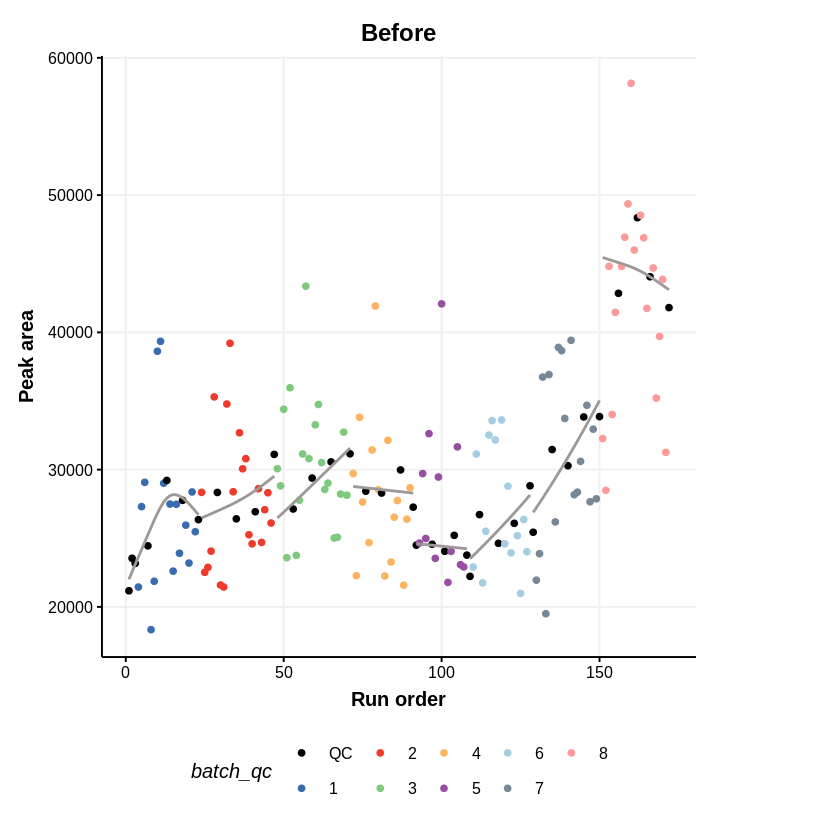

In [6]:
chart_plot(C, M, DE) + ylab('Peak area') + ggtitle('Before')

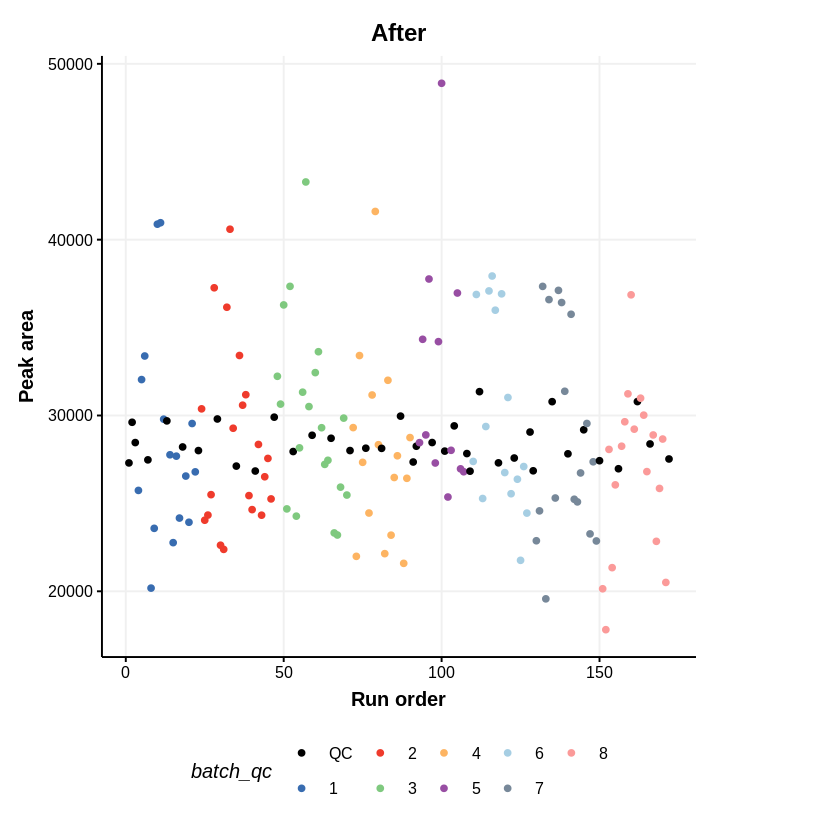

In [7]:
chart_plot(C, predicted(M)) + ylab('Peak area') + ggtitle('After')

In [8]:
# remove any feature not corrected by QCRCMS.
# This can occur if there are not enough measured QC values within a batch

M2 = filter_na_count(threshold=3, factor_name='Batch')

M2 = model_apply(M2, predicted(M))

# Calculate the no of features removed
nc = ncol(DE) - ncol(predicted(M2))

cat(paste0('Number of features removed: ', nc))

Number of features removed: 425

In [9]:
# feature filtering
# 1. kruskal-wallist to identify features not reliably detected in the QC samples (p < 0.0001) of all batches
M3 = kw_rank_sum(
      alpha=0.0001,
      mtc='none',
      factor_names='Batch',
      predicted='significant'
    ) +
    filter_by_name(
      mode='exclude',
      dimension = 'variable',
      seq_in = 'names', 
      names='seq_fcn', # this is a placeholder and will be replaced by seq_fcn
      seq_fcn=function(x){return(x[,1])}
    )
M3 = model_apply(M3, predicted(M2))

nc = ncol(predicted(M2)) - ncol(predicted(M3))
cat(paste0('Number of features removed: ', nc))

Number of features removed: 262

In [10]:
# 2. Wilcoxon Signed-rank test to identify features that aren't representative of the average of the biological samples (p < 1e-14)
M4 = wilcox_test(
      alpha=1e-14,
      factor_names='Type', 
      mtc='none', 
      predicted = 'significant'
    ) +
    filter_by_name(
      mode='exclude',
      dimension='variable',
      seq_in='names', 
      names='place_holder'
    )
M4 = model_apply(M4, predicted(M3))

nc = ncol(predicted(M3)) - ncol(predicted(M4))
cat(paste0('Number of features removed: ', nc))

Number of features removed: 169

In [11]:
# 3. RSD filter to remove features w/ high analytical variation (QC RSD > 20 removed)
M5 = rsd_filter(
     rsd_threshold=20,
     factor_name='Type'
)
M5 = model_apply(M5,predicted(M4))

nc = ncol(predicted(M4)) - ncol(predicted(M5))
cat(paste0('Number of features removed: ', nc))

Number of features removed: 53

In [12]:
# normalization, missing value imputation & scaling
# prepare the data for multivariate analysis by accounting for sample concentration differences, imputing missing values & scaling the data
M6 = pqn_norm(qc_label = 'QC', factor_name = 'Type') + 
    knn_impute(neighbours = 5) + 
    glog_transform(qc_label = 'QC', factor_name = 'Type')

M6 = model_apply(M6, predicted(M5))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


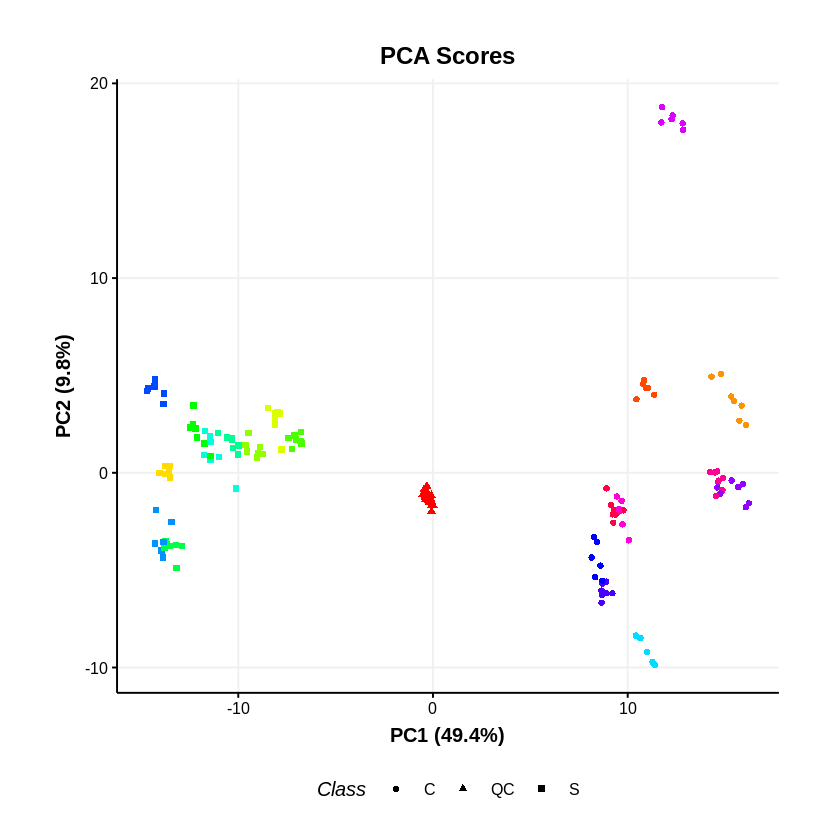

In [13]:
# EDA, Visualization
# PCA
M7  = mean_centre() + PCA(number_components = 2)

# apply model sequence to data
M7 = model_apply(M7,predicted(M6))

# plot pca scores
C = pca_scores_plot(factor_name=c('Sample_Rep','Class'),ellipse='none')
chart_plot(C,M7[2]) + coord_fixed() +guides(colour=FALSE)

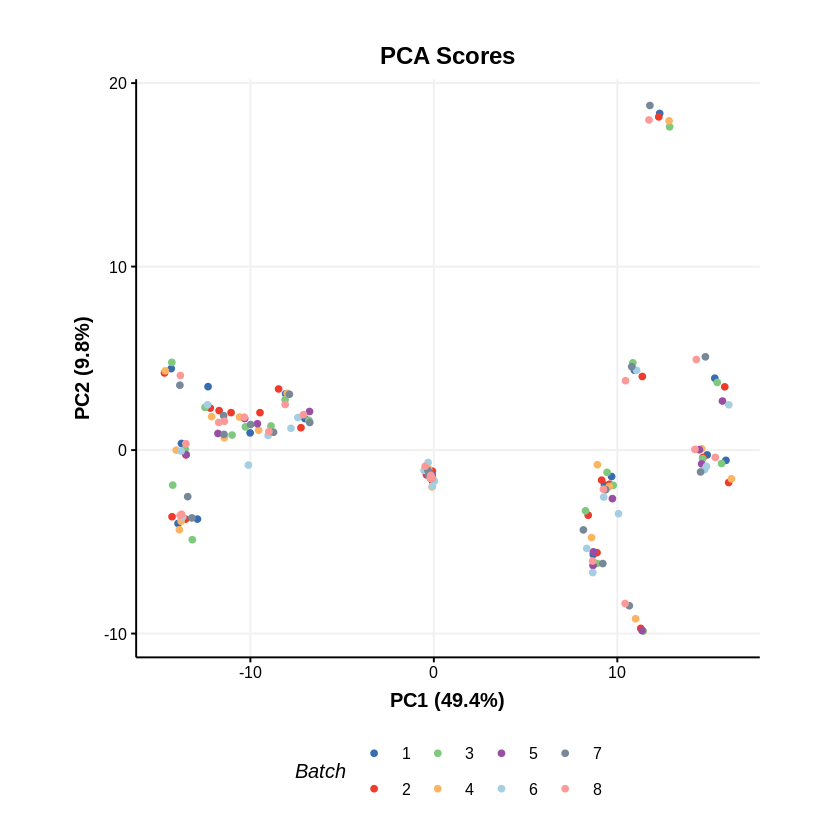

In [14]:
C = pca_scores_plot(factor_name = c('Batch'), ellipse = 'none')
chart_plot(C, M7[2]) + coord_fixed()

In [15]:
M7

A model_seq object containing:

[1]
A "mean_centre" object
----------------------
name:          Mean centre
description:   The mean sample is subtracted from all samples in the data matrix. The features in the centred
                 matrix all have zero mean.
input params:  mode 
outputs:       centred, mean_data, mean_sample_meta 
predicted:     centred
seq_in:        data

[2]
A "PCA" object
--------------
name:          Principal Component Analysis (PCA)
description:   PCA is a multivariate data reduction technique. It summarises the data in a smaller number of
                 Principal Components that maximise variance.
input params:  number_components 
outputs:       scores, loadings, eigenvalues, ssx, correlation, that 
predicted:     that
seq_in:        data


## Partial Least Squares (PLS) analysis of a untargeted LC-MS-based clinical metabolomics dataset

**1. Dataset**

The objective of the original study was to: > …study the influence of age, body mass index (bmi), and gender on metabolite concentrations in urine, by analysing 183 samples from a cohort of adults with liquid chromatography coupled to high-resolution mass spectrometry.

Thevenot et al. (2015)

The “Sacurine” dataset needs to be converted to a `DatasetExperiment` object. The ropls package provides the data as a list containing a `dataMatrix`, `sampleMetadata` and `variableMetadata`.

**2. Preprocessing**

It's already preprocessed

'After signal drift and bath effect correction of intensities, each urine profile was normalized by osmolality of the sample. Finally, the data were log10 transformed

**3. EDA**

**4. PLS analysis**

In [16]:
data('sacurine', package = 'ropls')

In [ ]:
head(sacurine)

In [19]:
# move the annotations to a new column and rename the features by index to avoid issues
# later when data.frames get transposed and names get checked/changed

sacurine$variableMetadata$annotation <- rownames(sacurine$variableMetadata)
rownames(sacurine$variableMetadata) <- 1:nrow(sacurine$variableMetadata)
colnames(sacurine$dataMatrix) <- 1:ncol(sacurine$dataMatrix)

# Create DatasetExperiment
DE <- DatasetExperiment(data = data.frame(sacurine$dataMatrix),
                        sample_meta = sacurine$sampleMetadata,
                        variable_meta = sacurine$variableMetadata,
                        name = 'Sacurine data',
                        description = 'See ropls package documentation for details')

DE

A "DatasetExperiment" object
----------------------------
name:          Sacurine data
description:   See ropls package documentation for details
data:          183 rows x 109 columns
sample_meta:   183 rows x 3 columns
variable_meta: 109 rows x 4 columns

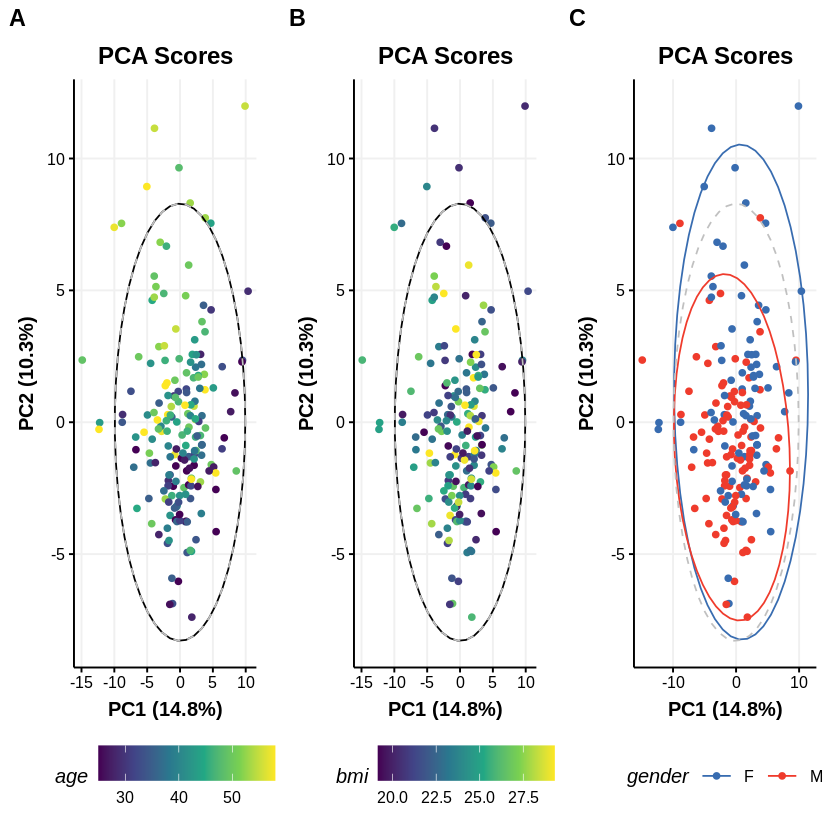

In [20]:
# EDA
# prepare model sequence
M = autoscale() + PCA(number_components = 5)

# apply model sequence to dataset
M = model_apply(M, DE)

# PCA scores plot
g <- list()

for (k in colnames(DE$sample_meta)) {
  C <- pca_scores_plot(factor_name = k)
  g[[k]] = chart_plot(C, M[2])
}

plot_grid(plotlist = g, nrow = 1, align = 'vh', labels = c('A', 'B', 'C'))

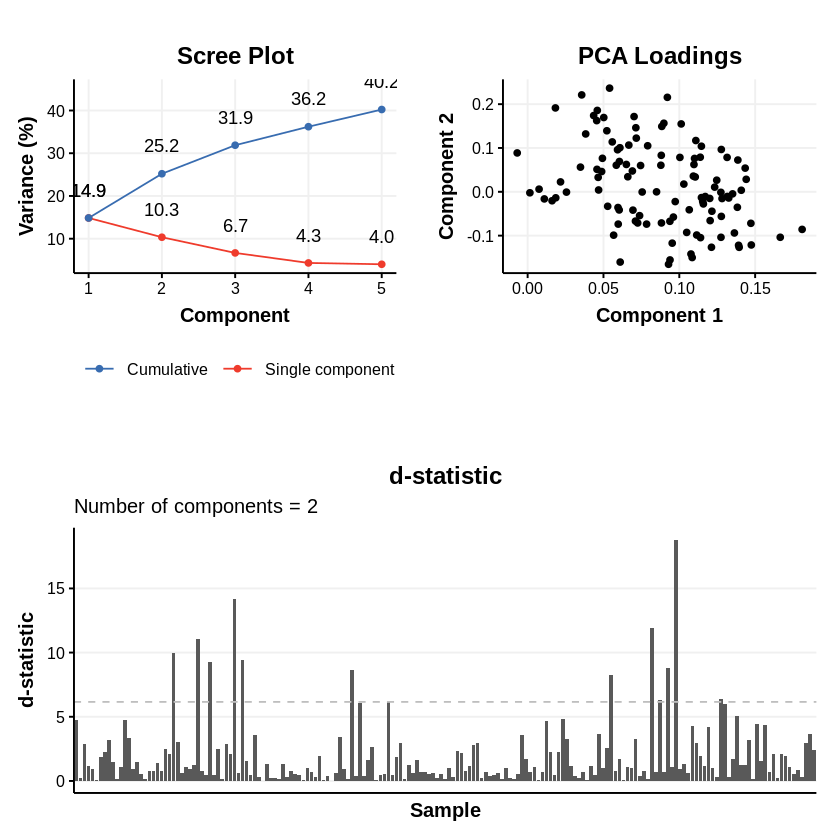

In [21]:
C = pca_scree_plot()
g1 = chart_plot(C,M[2])

C = pca_loadings_plot()
g2 = chart_plot(C,M[2])

C = pca_dstat_plot(alpha=0.95)
g3 = chart_plot(C,M[2])

p1=plot_grid(plotlist = list(g1,g2),align='h',nrow=1,axis='b')
p2=plot_grid(plotlist = list(g3),nrow=1)
plot_grid(p1,p2,nrow=2)

In [11]:
# PLS analysis
install.packages('pls')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



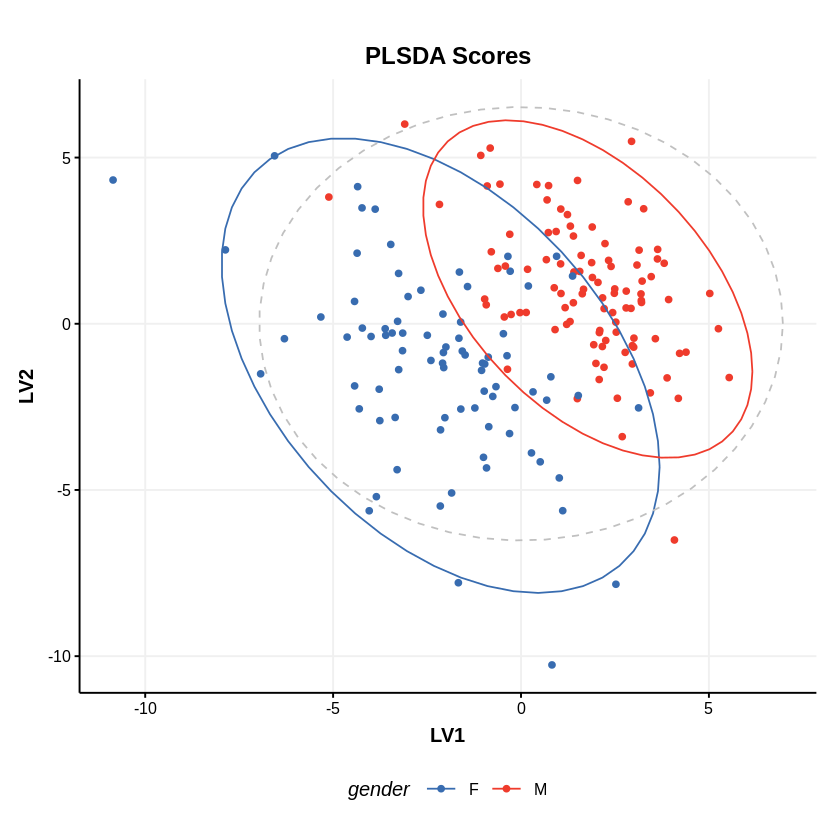

In [24]:

# model sequence
M = autoscale() + PLSDA(factor_name='gender')
M = model_apply(M,DE)

C = plsda_scores_plot(factor_name = 'gender')
chart_plot(C,M[2])

To compare the R2 values for the model in structToolbox we have to use a regression model, instead of a discriminant model. For this we convert the gender factor to a numeric variable before applying the model.

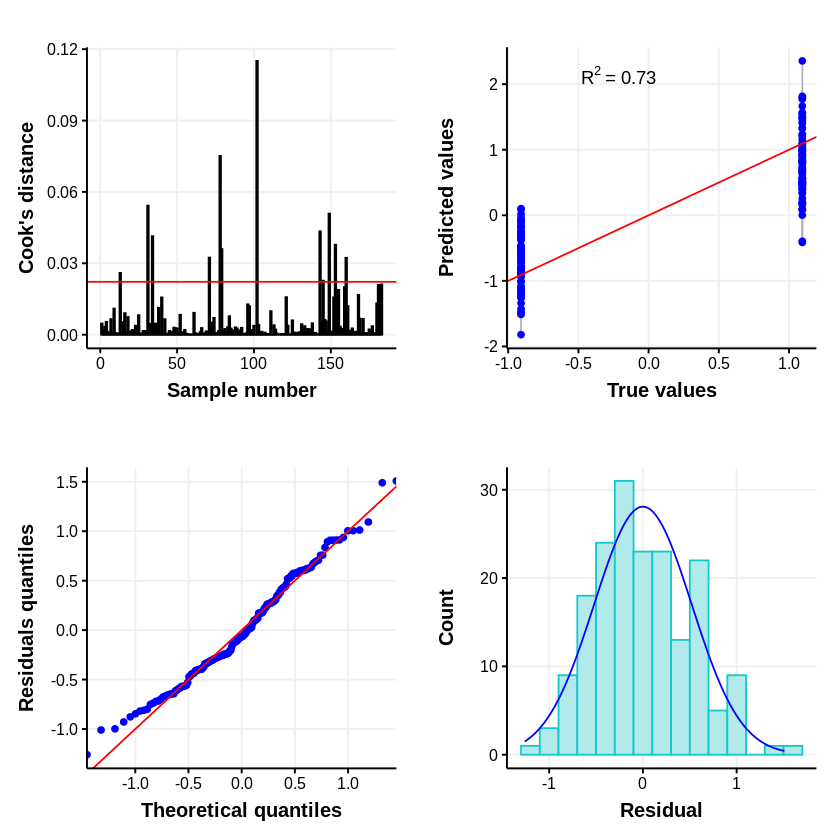

In [25]:
# convert gender to numeric
DE$sample_meta$gender = as.numeric(DE$sample_meta$gender)

# models sequence
M <- autoscale(mode = 'both') + PLSR(factor_name = 'gender', number_components = 3)
M <- model_apply(M, DE)

# some diagnostic charts
C = plsr_cook_dist()
g1 = chart_plot(C,M[2])

C = plsr_prediction_plot()
g2 = chart_plot(C,M[2])

C = plsr_qq_plot()
g3 = chart_plot(C,M[2])

C = plsr_residual_hist()
g4 = chart_plot(C,M[2])

plot_grid(plotlist = list(g1,g2,g3,g4), nrow=2,align='vh')

The `ropls` package automatically applies cross-validation to asses the performance of the PLSDA model. In `structToolbox` this is applied separately to give more control over the approach used if desired. The default cross-validation used by the `ropls` package is 7-fold cross-validation and we replicate that here.

In [29]:
M = kfold_xval(folds=7, factor_name = 'gender') *
  (autoscale(mode='both') + PLSR(factor_name = 'gender'))
M = run(M, DE, r_squared())
M

A "kfold_xval" object
---------------------
name:          k-fold cross-validation
description:   k-fold cross-validation is an iterative approach applied to validate models. The samples are
                 divided into k "folds", or subsets. Each subset is excluded from model
                 training and used for model validation once, resulting in a single left-out
                 prediction for each sample. Model performance metrics are then computed for
                 the training and test sets across all folds.
input params:  folds, method, factor_name 
outputs:       results, metric, metric.train, metric.test 
models:        a model_seq with 2 steps
result:        results    (data.frame)


In [34]:
M@metric.test

[1] 0.5460723

In [35]:
M@metric.train

[1] 0.6975706 0.6798415 0.6466710 0.6532914 0.7109769 0.6707770 0.6935344

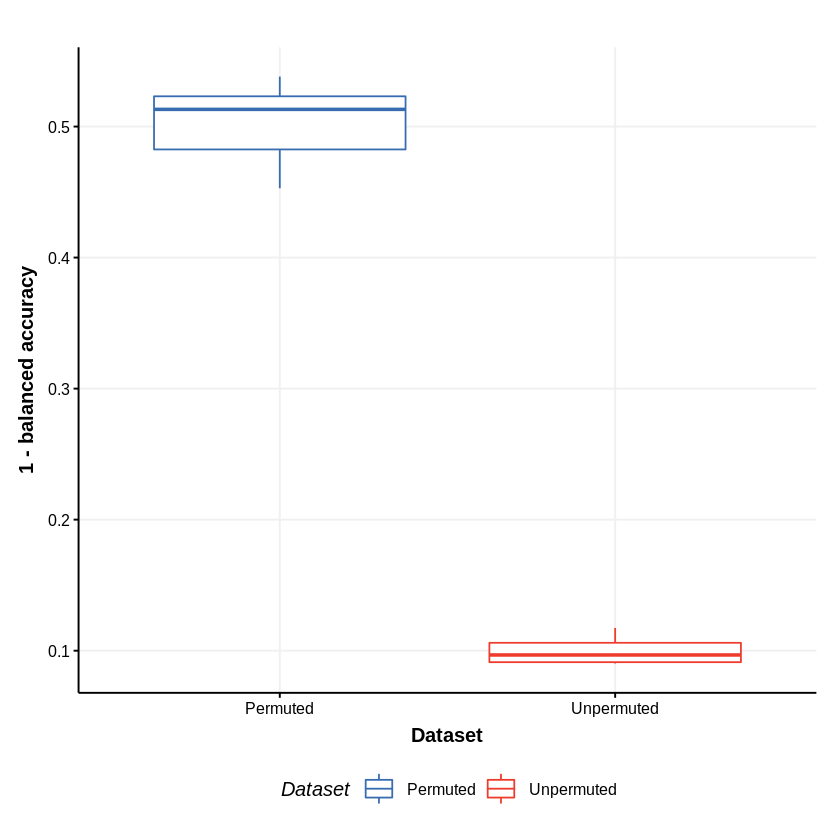

In [36]:
# the validity of th emodel can be further assessed using permutation testing. For this we'll return to a discriminant model
# reset gender to original factor
DE$sample_meta$gender <- sacurine$sampleMetadata$gender

# Model sequence
M <- permutation_test(number_of_permutations = 10, factor_name = 'gender') *
    kfold_xval(folds=7, factor_name = 'gender') *
    (autoscale() + PLSDA(factor_name = 'gender', number_components = 3))

M <- run(M, DE, balanced_accuracy())

C <- permutation_test_plot(style = 'boxplot')
chart_plot(C, M) + ylab('1 - balanced accuracy')

The permuted models have a balanced accuracy of around 50%, which is to be expected for a dataset with two groups. The unpermuted models have a balanced accuracy of around 90% and is therefore much better than might be expected to occur by chance.

## Univariate and multivariate statistical analysis of a NMR-based clinical metabolomics

**1. Dataset**

The 1H-NMR dataset used and described in Mendez et al., (2020) and in this vignette contains processed spectra of urine samples obtained from gastric cancer and healthy patients Chan et al., (2016). The experimental raw data is available through Metabolomics Workbench (PR000699) and the processed version is available from [here](https://github.com/CIMCB/MetabWorkflowTutorial/raw/master/GastricCancer_NMR.xlsx) as an Excel data file.

As a first step we need to reorganise and convert the Excel data file into a DatasetExperiment object. Using the openxlsx package the file can be read directly into an R data.frame and then manipulated as required.

**2. Pre-processing & quality assessment**

**3. Univariate statistics**

t-test

**4. Multivariate Statistics & ML**

- training and test set

- optimal # of PLS components

- PLS model evaluation

- Permutation test

- PLS projection plots

- PLS feature importance

regression coefficients and VIP scores can be used to estimate the importance of individual features to the PLS model

In [4]:
url = 'https://github.com/CIMCB/MetabWorkflowTutorial/raw/master/GastricCancer_NMR.xlsx'

# read in file directly from github...
# X=read.xlsx(url)

# ...or use BiocFileCache
path = bfcrpath(bfc,url)
X = read.xlsx(path)

# sample meta data
SM=X[,1:4]
rownames(SM)=SM$SampleID
# convert to factors
SM$SampleType=factor(SM$SampleType)
SM$Class=factor(SM$Class)
# keep a numeric version of class for regression
SM$Class_num = as.numeric(SM$Class)

## data matrix
# remove meta data
X[,1:4]=NULL
rownames(X)=SM$SampleID

# feature meta data
VM=data.frame(idx=1:ncol(X))
rownames(VM)=colnames(X)

# prepare DatasetExperiment
DE = DatasetExperiment(
    data=X,
    sample_meta=SM,
    variable_meta=VM,
    description='1H-NMR urinary metabolomic profiling for diagnosis of gastric cancer',
    name='Gastric cancer (NMR)')

DE

adding rname 'https://github.com/CIMCB/MetabWorkflowTutorial/raw/master/GastricCancer_NMR.xlsx'



A "DatasetExperiment" object
----------------------------
name:          Gastric cancer (NMR)
description:   1H-NMR urinary metabolomic profiling for diagnosis of gastric cancer
data:          140 rows x 149 columns
sample_meta:   140 rows x 5 columns
variable_meta: 149 rows x 1 columns

In [5]:
# pre-processing & quality assessment
# model sequence
M <- rsd_filter(rsd_threshold = 20, qc_label = 'QC', factor_name = 'Class') + 
    mv_feature_filter(threshold = 10, method = 'across', factor_name = 'Class')

# apply model
M <- model_apply(M, DE)

filtered = predicted(M)

filtered

A "DatasetExperiment" object
----------------------------
name:          Gastric cancer (NMR)
description:   1H-NMR urinary metabolomic profiling for diagnosis of gastric cancer
data:          140 rows x 53 columns
sample_meta:   140 rows x 5 columns
variable_meta: 53 rows x 1 columns

After suitable scaling and transformation PCA can be used to assess data quality. It is expected that the biological variance (samples) will be larger than the technical variance (QCs). In the workflow that we are reproducing (link) the following steps were applied:

- log10 transform

- autoscaling (scaled to unit variance)

- knn imputation (3 neighbours)

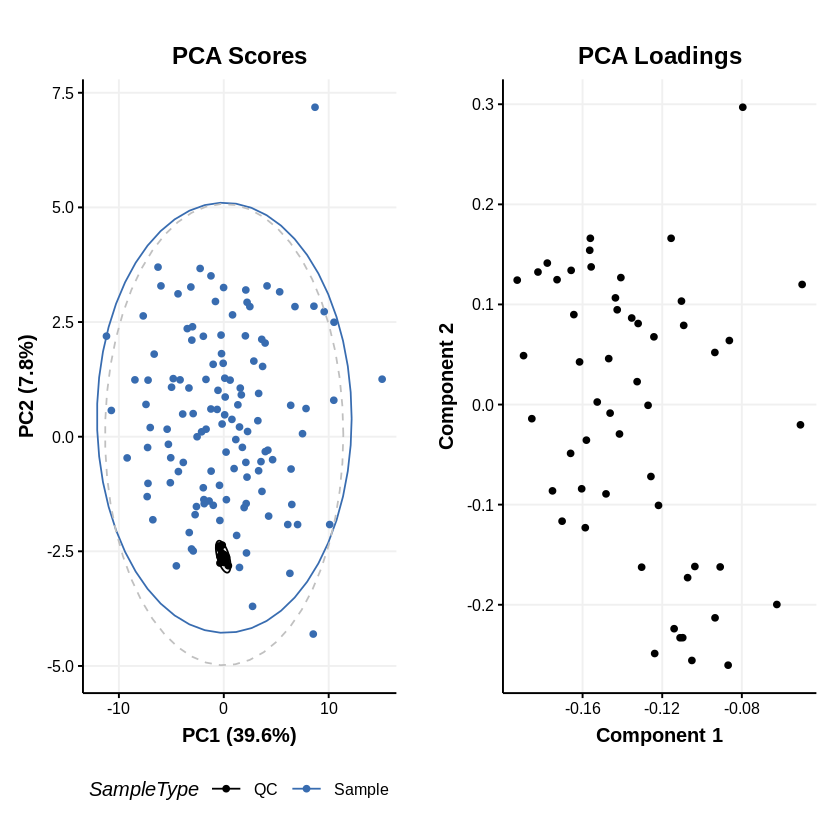

In [60]:
# model sequence
M <- log_transform(base = 10) + 
    autoscale() + 
    knn_impute(neighbours = 3) + 
    PCA(number_components = 10)

# apply model sequence 
M <- model_apply(M, filtered) 

TSI <- predicted(M[3])

# scores plot
C <- pca_scores_plot(factor_name = 'SampleType')
g1 <- chart_plot(C, M[4])

# loadings plot
C <- pca_loadings_plot()
g2 <- chart_plot(C, M[4])

plot_grid(g1, g2, align = 'hv', nrow=1, axis='tblr')

In [61]:
# For brevity only the ttest is calculated for comparison with the workflow we are following (link). 
# The QC samples need to be excluded, and the data reduced to only the GC and HE groups.
# model
TT = filter_smeta(mode='include', factor_name = 'Class', levels=c('GC', 'HE')) +
      ttest(alpha=0.05, mtc='fdr', factor_names = 'Class')

# apply model
TT <- model_apply(TT, filtered)

# keep the data filtered by group for later
filtered <- predicted(TT[1])

# convert to dataframe
out <- as_data_frame(TT[2])

head(out)

,t_statistic,t_p_value,t_significant,estimate.mean.GC,estimate.mean.HE,lower,upper
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
M4,-3.5392652,0.008421042,TRUE,26.47778,51.73947,-39.56162,-10.961769
M5,1.4296604,0.410396437,FALSE,265.11860,169.91500,-38.04747,228.454679
M7,2.7456506,0.051494976,FALSE,118.52558,53.98718,17.60818,111.468619
M8,-2.1294198,0.178392032,FALSE,54.39535,79.26750,-48.20069,-1.543611
M11,0.5106536,0.776939682,FALSE,201.34390,171.27949,-87.30604,147.434869
M14,-1.4786810,0.403091881,FALSE,61.53171,83.90250,-52.57754,7.835950


In [43]:
# multivariate
# prepare model
M = stratified_split(p_train=0.75,factor_name='Class')
# apply to filtered data
M = model_apply(M,filtered)
# get data from object
train = M$training
train

A "DatasetExperiment" object
----------------------------
name:          Gastric cancer (NMR)(Training set)
description:   • 1H-NMR urinary metabolomic profiling for diagnosis of gastric cancer
               • A subset of the data has been selected as a training set
data:          62 rows x 53 columns
sample_meta:   62 rows x 5 columns
variable_meta: 53 rows x 1 columns

In [44]:
test = M$testing

test

A "DatasetExperiment" object
----------------------------
name:          Gastric cancer (NMR)(Testing set)
description:   • 1H-NMR urinary metabolomic profiling for diagnosis of gastric cancer
               • A subset of the data has been selected as a test set
data:          21 rows x 53 columns
sample_meta:   21 rows x 5 columns
variable_meta: 53 rows x 1 columns

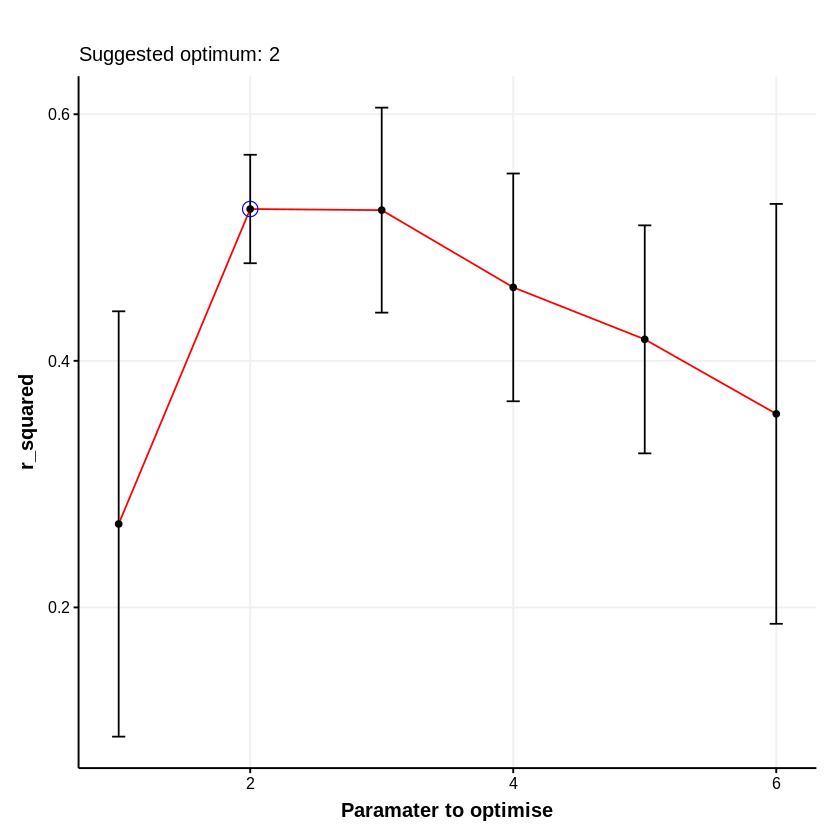

In [45]:
# optimal number of PLS components
# scale/transform training data
M = log_transform(base = 10) +
    autoscale() + 
    knn_impute(neighbours = 3,by='samples')

# apply model
M = model_apply(M,train)

# get scaled/transformed training data
train_st = predicted(M)

# prepare model sequence
MS = grid_search_1d(
        param_to_optimise = 'number_components',
        search_values = as.numeric(c(1:6)),
        model_index = 2,
        factor_name = 'Class_num',
        max_min = 'max') *
     permute_sample_order(
        number_of_permutations = 10) *
     kfold_xval(
        folds = 5,
        factor_name = 'Class_num') * 
     (mean_centre(mode='sample_meta')+
      PLSR(factor_name='Class_num'))

# run the validation
MS = struct::run(MS,train_st,r_squared())

#
C = gs_line()
chart_plot(C,MS)

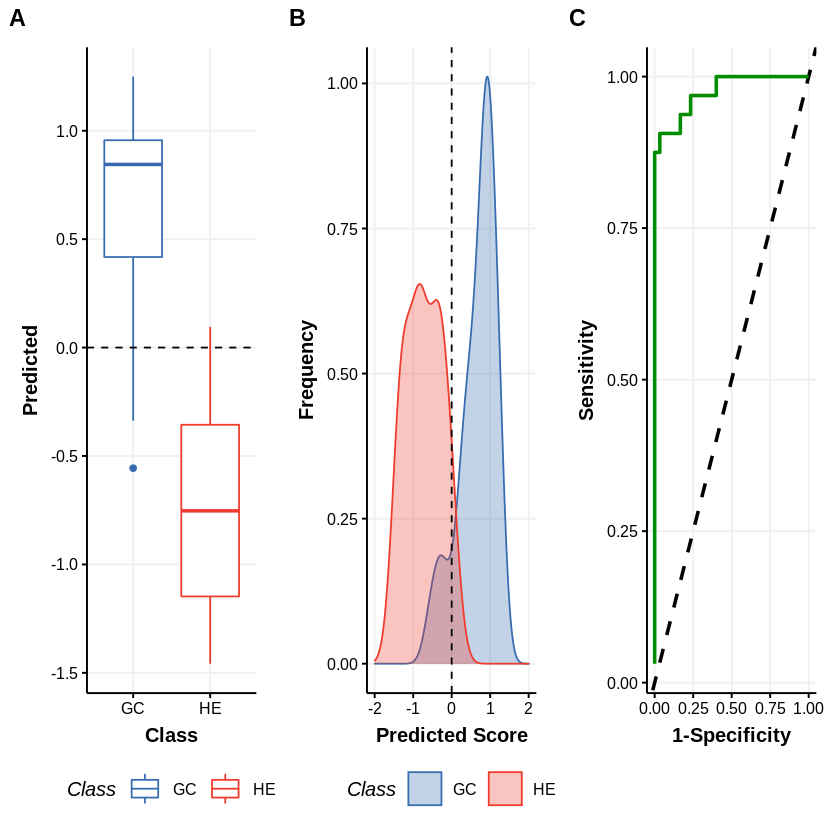

In [46]:
# model evaluation
# prepare the discriminant model
P = PLSDA(number_components = 2, factor_name='Class')

# apply the model
P = model_apply(P,train_st)

# charts
C = plsda_predicted_plot(factor_name='Class',style='boxplot')
g1 = chart_plot(C,P)

C = plsda_predicted_plot(factor_name='Class',style='density')
g2 = chart_plot(C,P)+xlim(c(-2,2))

C = plsda_roc_plot(factor_name='Class')
g3 = chart_plot(C,P)

plot_grid(g1,g2,g3,align='vh',axis='tblr',nrow=1, labels=c('A','B','C'))

In [48]:
MET = calculate(AUC(), P$y$Class, P$yhat[, 1])
MET

A "AUC" object
--------------
name:          Area under ROC curve
description:   The area under the ROC curve of a classifier is estimated using the trapezoid method.
value:         0.9739583


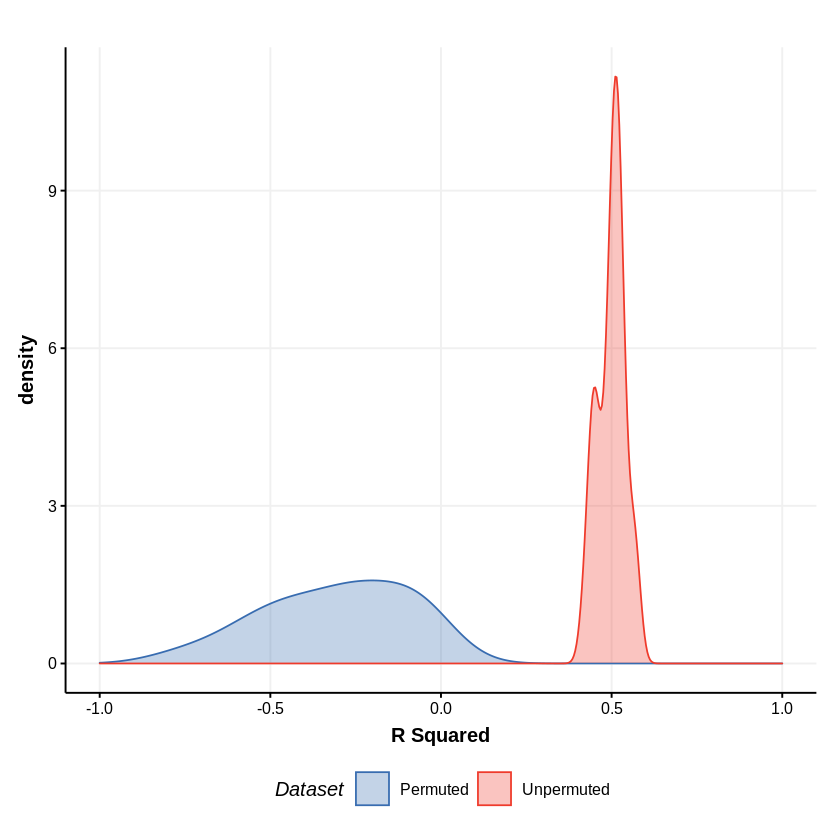

In [50]:
# Permutation test
# model sequence
MS = permutation_test(number_of_permutations = 20,factor_name = 'Class_num') * 
     kfold_xval(folds = 5,factor_name = 'Class_num') *
     (mean_centre(mode='sample_meta') + PLSR(factor_name='Class_num', number_components = 2))

# run iterator
MS = struct::run(MS,train_st,r_squared())

# chart
C = permutation_test_plot(style = 'density') 
chart_plot(C,MS) + xlim(c(-1,1)) + xlab('R Squared')


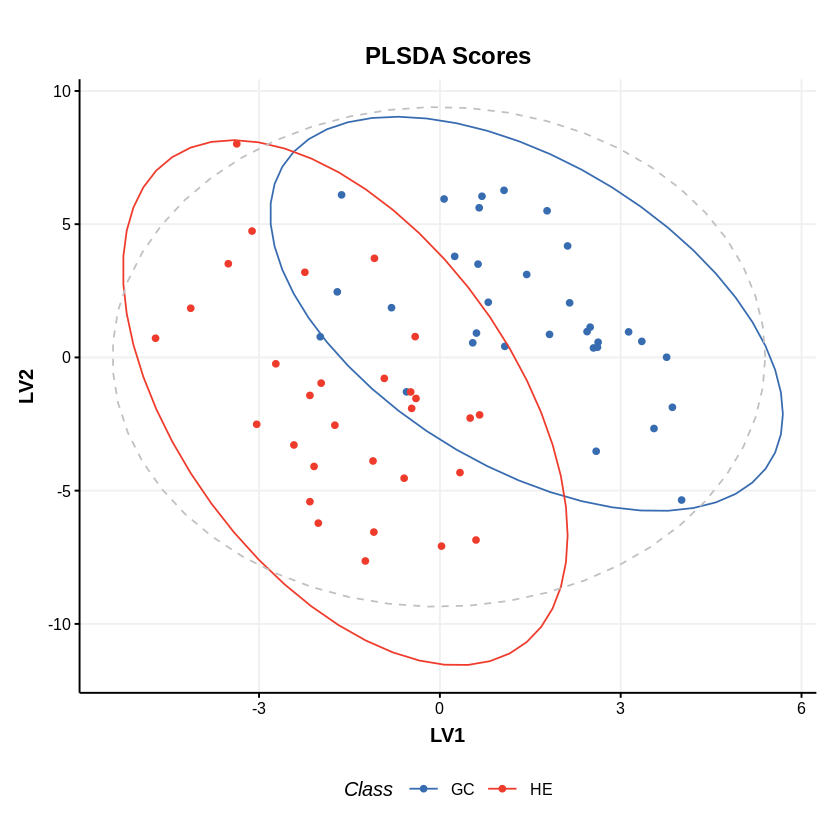

In [51]:
# prepare the discriminant model
P = PLSDA(number_components = 2, factor_name='Class')

# apply the model
P = model_apply(P,train_st)

C = plsda_scores_plot(components=c(1,2),factor_name = 'Class')
chart_plot(C,P)

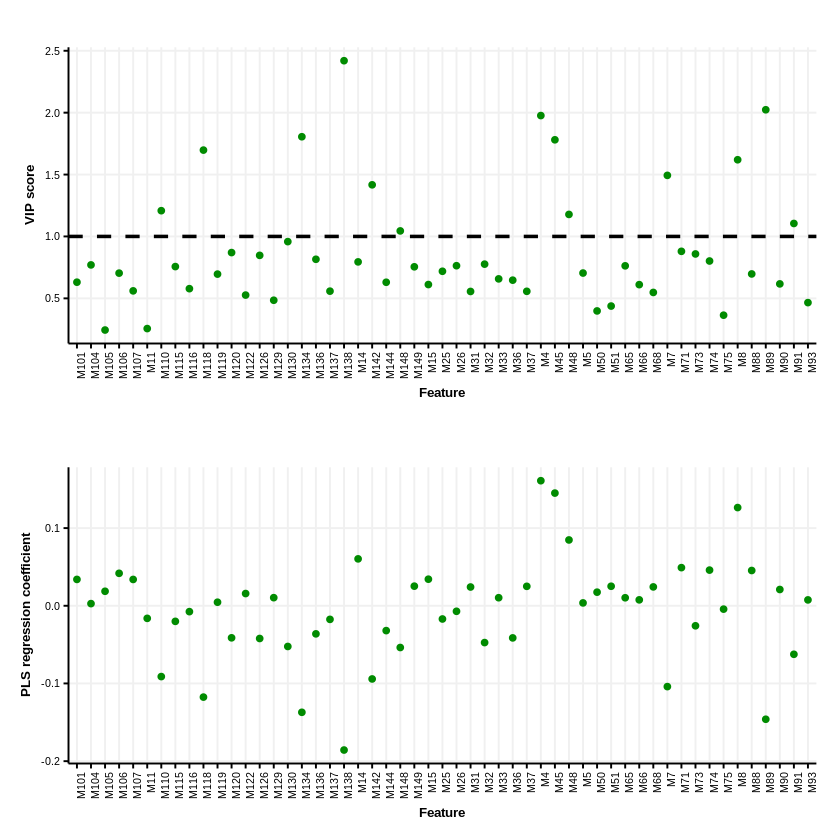

In [52]:
# prepare chart
C = plsda_vip_plot(level='HE')
g1 = chart_plot(C,P)

C = plsda_regcoeff_plot(level='HE')
g2 = chart_plot(C,P)

plot_grid(g1,g2,align='hv',axis='tblr',nrow=2)

## Classification of Metabolomics using SVM

The 1H-NMR dataset used and described in Mendez et al., (2020) and in this vignette contains processed spectra of urine samples obtained from gastric cancer and healthy patients Chan et al., (2016). The raw experimental data is available through Metabolomics Workbench (PR000699) and the processed version is available from [here](https://github.com/CIMCB/MetabWorkflowTutorial/raw/master/GastricCancer_NMR.xlsx) as an Excel data file.

In [9]:
url='https://github.com/CIMCB/MetabWorkflowTutorial/raw/master/GastricCancer_NMR.xlsx'
path = bfcrpath(bfc,url)
X = read.xlsx(path)

# sample meta data
SM=X[,1:4]
rownames(SM)=SM$SampleID
# convert to factors
SM$SampleType=factor(SM$SampleType)
SM$Class=factor(SM$Class)
# keep a numeric version of class for regression
SM$Class_num = as.numeric(SM$Class)

## data matrix
# remove meta data
X[,1:4]=NULL
rownames(X)=SM$SampleID

# feature meta data
VM=data.frame(idx=1:ncol(X))
rownames(VM)=colnames(X)

# prepare DatasetExperiment
DE = DatasetExperiment(
    data=X,
    sample_meta=SM,
    variable_meta=VM,
    description='1H-NMR urinary metabolomic profiling for diagnosis of gastric cancer',
    name='Gastric cancer (NMR)')

M = rsd_filter(rsd_threshold=20,qc_label='QC',factor_name='Class') +
    mv_feature_filter(threshold = 10,method='across',factor_name='Class') +
    log_transform(base = 10) +
    autoscale() + 
    knn_impute(neighbours = 3)

M = model_apply(M,DE)
DE = predicted(M)


## -----------------------------------------------------------------------------
# summary of DatasetExperiment object
DE

A "DatasetExperiment" object
----------------------------
name:          
description:   
data:          140 rows x 53 columns
sample_meta:   140 rows x 5 columns
variable_meta: 53 rows x 1 columns

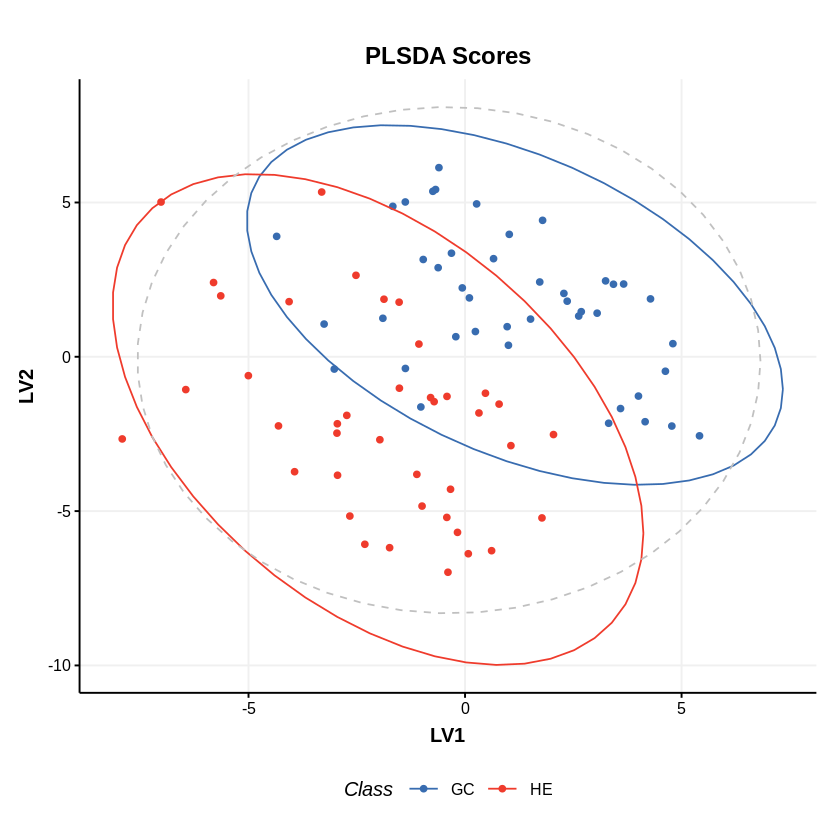

In [12]:
# model sequence and pls model (NB data already centred)
MS = filter_smeta(mode = 'include', levels = c('GC','HE'), factor_name = 'Class') +
     PLSDA(factor_name = 'Class',number_components = 2)

# apply PLS model
MS = model_apply(MS,DE)

# plot the data
C = plsda_scores_plot(factor_name = 'Class')
chart_plot(C,MS[2])

In [13]:
# new DatasetExperiment object from the PLS scores
DE2 = DatasetExperiment(
  data = MS[2]$scores, 
  sample_meta = predicted(MS[1])$sample_meta,
  variable_meta = data.frame('LV'=c(1,2),row.names = colnames(MS[2]$scores)),
  name = 'Illustrativate SVM dataset',
  description = 'Generated by applying PLS to the processed Gastric cancer (NMR) dataset'
)

DE2

A "DatasetExperiment" object
----------------------------
name:          Illustrativate SVM dataset
description:   Generated by applying PLS to the processed Gastric cancer (NMR) dataset
data:          83 rows x 2 columns
sample_meta:   83 rows x 5 columns
variable_meta: 2 rows x 1 columns

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




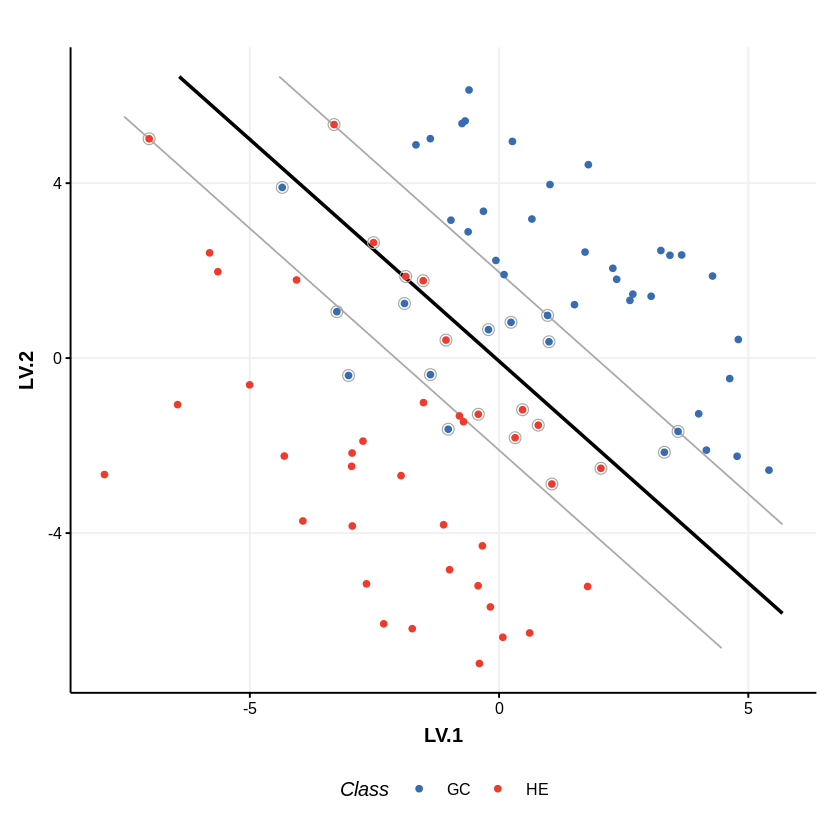

In [17]:
# SVM linear model
install.packages('e1071')
M = SVM(factor_name = 'Class', kernel = 'linear')

M = model_apply(M, DE2)

C = svm_plot_2d(factor_name = 'Class')
chart_plot(C, M, DE2)

The SVM cost function applies a penalty to samples on the wrong side of the margins. A high penalty results in a narrow margin and tries to force more samples to be on the correct side of the boundary. A low penalty makes for a wider margin and is less strict about samples being misclassified. The optimal cost to use is data dependent.

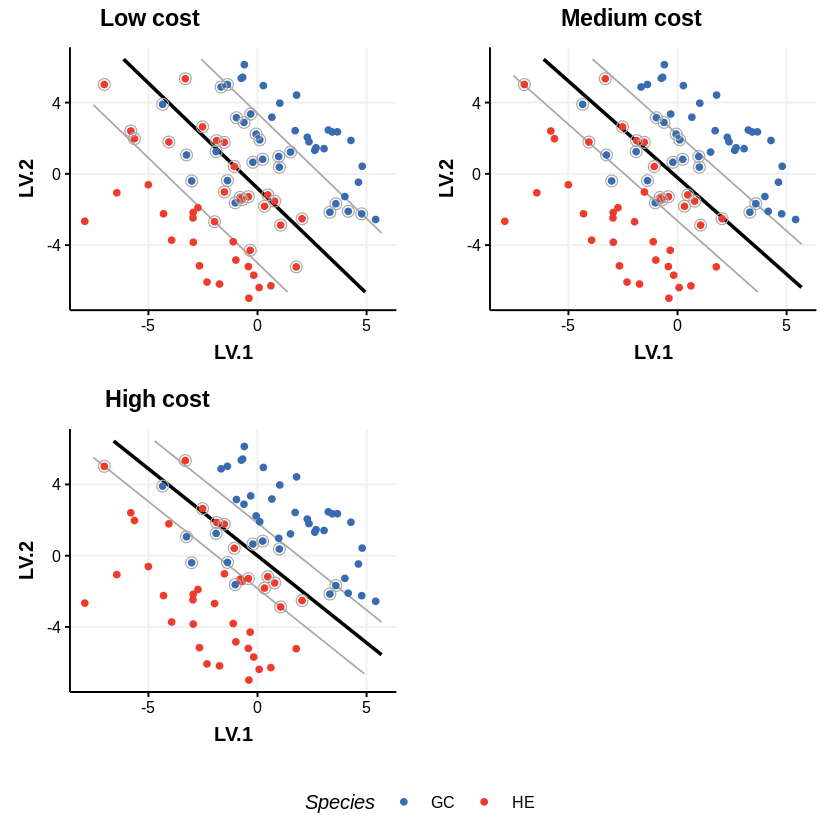

In [18]:
# low cost
M$cost=0.01
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g1=chart_plot(C,M,DE2)

# medium cost
M$cost=0.05
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g2=chart_plot(C,M,DE2)

# high cost
M$cost=100
M=model_apply(M,DE2)

C=svm_plot_2d(factor_name='Species')
g3=chart_plot(C,M,DE2)

# plot
prow <- plot_grid(
  g1 + theme(legend.position="none"),
  g2 + theme(legend.position="none"),
  g3 + theme(legend.position="none"),
  align = 'vh',
  labels = c("Low cost", "Medium cost", "High cost"),
  hjust = -1,
  nrow = 2
)

legend <- get_legend(
  # create some space to the left of the legend
  g1 + guides(color = guide_legend(nrow = 1)) +
  theme(legend.position = "bottom")
)

plot_grid(prow, legend, ncol=1, rel_heights = c(1, .1))

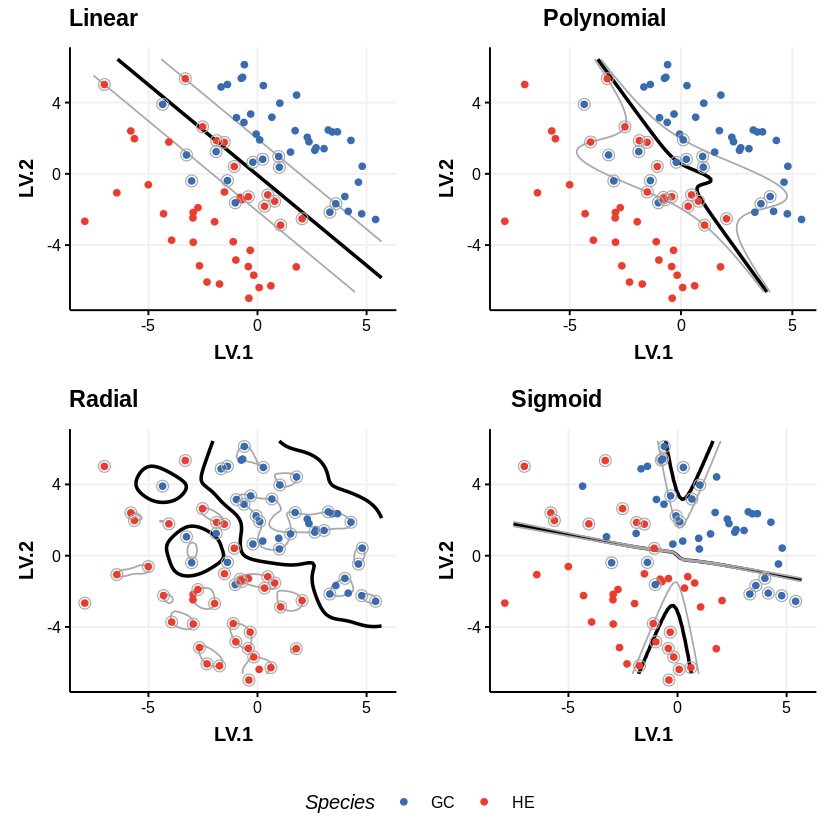

In [19]:
# SVM Kernel
# set a fixed cost for this comparison
M$cost=1

# linear kernel
M$kernel='linear'
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g1=chart_plot(C,M,DE2)

# polynomial kernel
M$kernel='polynomial'
M$gamma=1
M$coef0=0
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g2=chart_plot(C,M,DE2)

# rbf kernel
M$kernel='radial'
M$gamma=1
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g3=chart_plot(C,M,DE2)

# sigmoid kernel
M$kernel='sigmoid'
M$gamma=1
M$coef0=0
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g4=chart_plot(C,M,DE2)

# plot
prow <- plot_grid(
  g1 + theme(legend.position="none"),
  g2 + theme(legend.position="none"),
  g3 + theme(legend.position="none"),
  g4 + theme(legend.position="none"),
  align = 'vh',
  labels = c("Linear", "Polynomial", "Radial","Sigmoid"),
  hjust = -1,
  nrow = 2
)
legend <- get_legend(
  # create some space to the left of the legend
  g1 + guides(color = guide_legend(nrow = 1)) +
    theme(legend.position = "bottom")
)
plot_grid(prow, legend, ncol = 1, rel_heights = c(1, .1))

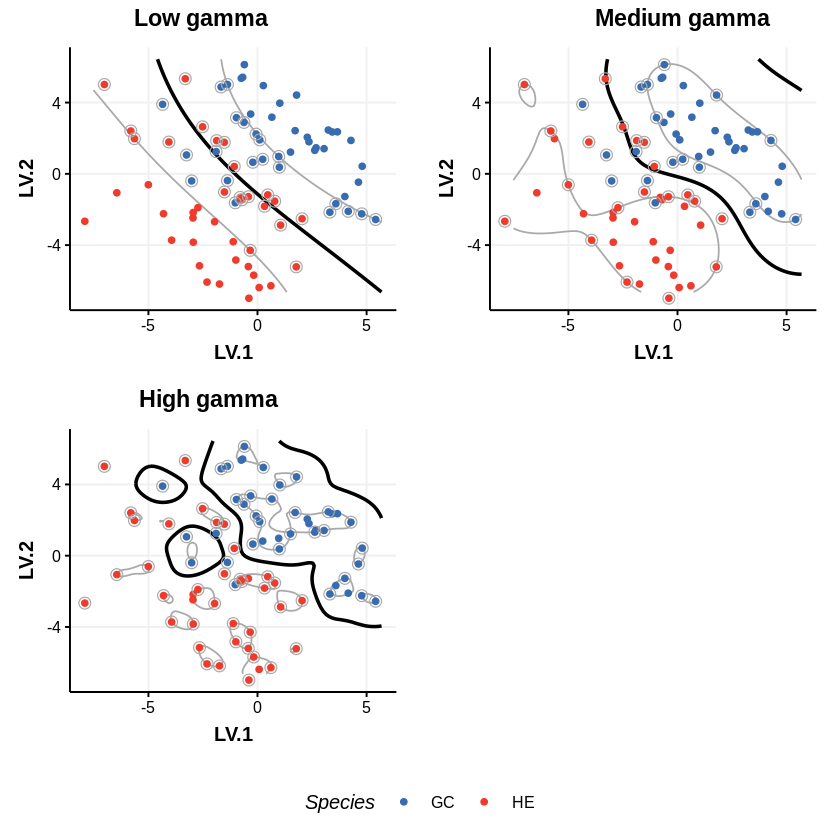

In [20]:
# parameters
# rbf kernel and cost
M$kernel = 'radial'
M$cost = 1

# low gamma
M$gamma=0.01
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g1=chart_plot(C,M,DE2)

# medium gamma
M$gamma=0.1
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g2=chart_plot(C,M,DE2)

# high gamma
M$gamma=1
M=model_apply(M,DE2)
C=svm_plot_2d(factor_name='Species')
g3=chart_plot(C,M,DE2)

# plot
prow <- plot_grid(
 g1 + theme(legend.position="none"),
 g2 + theme(legend.position="none"),
 g3 + theme(legend.position="none"),
 align = 'vh',
 labels = c("Low gamma", "Medium gamma", "High gamma"),
 hjust = -1,
 nrow = 2
)
legend <- get_legend(
  # create some space to the left of the legend
  g1 + guides(color = guide_legend(nrow = 1)) +
  theme(legend.position = "bottom")
)
plot_grid(prow, legend, ncol = 1, rel_heights = c(1, .1))

## EDA of LC-MS-based proteomics and metabolomics drom STATegraproject

In [21]:
# path to zip
zipfile = "https://raw.github.com/STATegraData/STATegraData/master/Script_STATegra_Proteomics.zip"

## retrieve from BiocFileCache
path = bfcrpath(bfc,zipfile)
temp = bfccache(bfc)

## ... or download to temp location
# path = tempfile()
# temp = tempdir()
# download.file(zipfile,path)

# unzip
unzip(path, files = "Proteomics_01_uniprot_canonical_normalized.txt", exdir=temp)
# read samples
all_data <-  read.delim(file.path(temp,"Proteomics_01_uniprot_canonical_normalized.txt"), as.is = TRUE, header = TRUE, sep = "\t")

adding rname 'https://raw.github.com/STATegraData/STATegraData/master/Script_STATegra_Proteomics.zip'



In [22]:
# extract data matrix
data = all_data[1:2527,51:86]
# shorten sample names
colnames(data) = lapply(colnames(data), function (x) substr(x, 27, nchar(x)))
# replace 0 with NA
data[data == 0] <- NA
# transpose
data=as.data.frame(t(data))

# prepare sample meta
SM = lapply(rownames(data),function(x) {
  s=strsplit(x,'_')[[1]] # split at underscore
  out=data.frame(
    'treatment' = s[[1]],
    'time' = substr(s[[2]],1,nchar(s[[2]])-1) ,    
    'batch' = substr(s[[3]],6,nchar(s[[3]])),
    'condition' = substr(x,1,6) # interaction between treatment and time
  )
  return(out)
})
SM = do.call(rbind,SM)
rownames(SM)=rownames(data)
# convert to factors
SM$treatment=factor(SM$treatment)
SM$time=ordered(SM$time,c("0","2","6","12","18","24"))
SM$batch=ordered(SM$batch,c(1,3,4,5,6,7))
SM$condition=factor(SM$condition)

# variable meta data
VM = all_data[1:2527,c(1,6,7)]
rownames(VM)=colnames(data)

# prepare DatasetExperiment
DS = DatasetExperiment(
  data = data, 
  sample_meta = SM, 
  variable_meta = VM, 
  name = 'STATegra Proteomics',
  description = 'downloaded from: https://github.com/STATegraData/STATegraData/'
)
DS

A "DatasetExperiment" object
----------------------------
name:          STATegra Proteomics
description:   downloaded from: https://github.com/STATegraData/STATegraData/
data:          36 rows x 2527 columns
sample_meta:   36 rows x 4 columns
variable_meta: 2527 rows x 3 columns

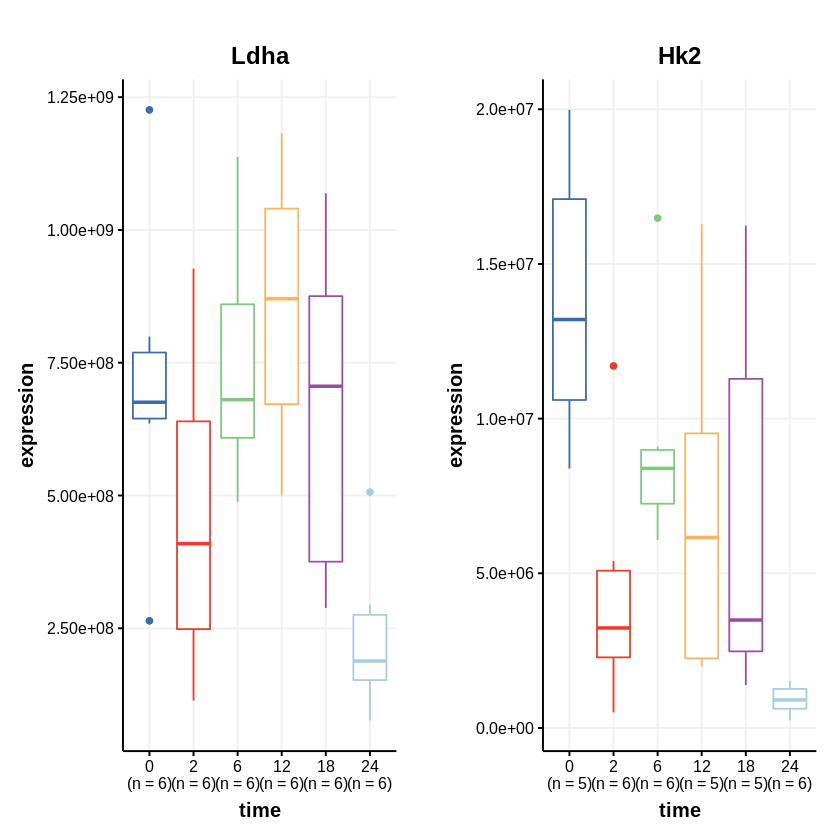

In [23]:
# plot some reporter genes
Ldha <- which(DS$variable_meta$Gene.names == 'Ldha')
Hk2 <- which(DS$variable_meta$Gene.names == 'Hk2')

# chart object
C = feature_boxplot(feature_to_plot=Ldha,factor_name='time',label_outliers=FALSE)
g1=chart_plot(C,DS)+ggtitle('Ldha')+ylab('expression')
C = feature_boxplot(feature_to_plot=Hk2,factor_name='time',label_outliers=FALSE)
g2=chart_plot(C,DS)+ggtitle('Hk2')+ylab('expression')

plot_grid(g1,g2,nrow=1,align='vh',axis='tblr')

In [24]:
M = log_transform(base=2) + mean_of_medians(factor_name = 'condition')

M = model_apply(M, DS)

DST = predicted(M)

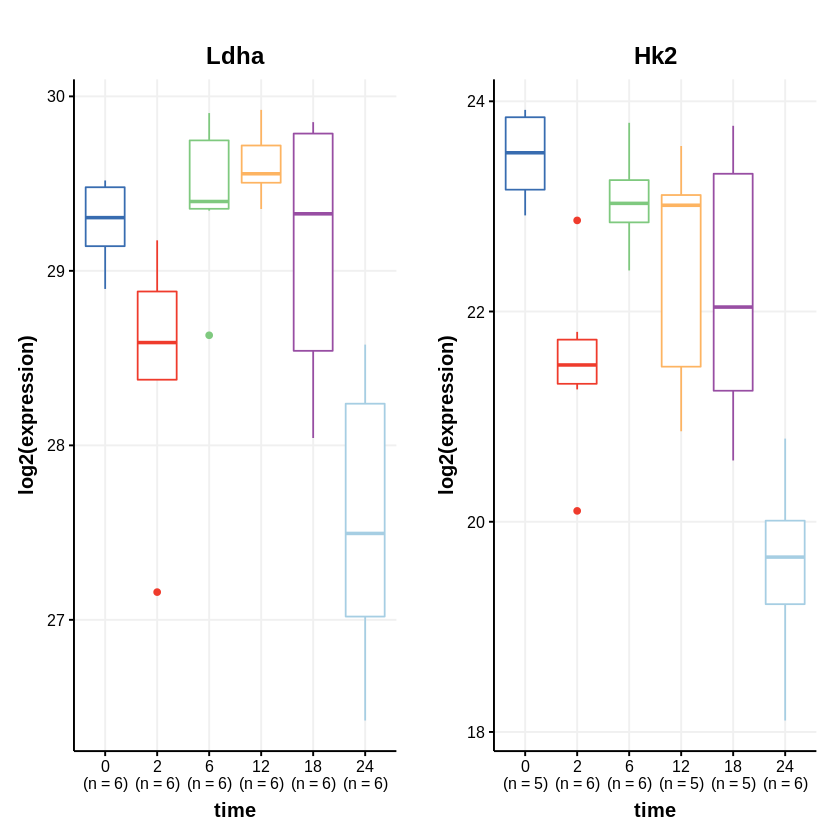

In [25]:
# chart object
C = feature_boxplot(feature_to_plot=Ldha,factor_name='time',label_outliers=FALSE)
g1=chart_plot(C,DST)+ggtitle('Ldha')+ylab('log2(expression)')
C = feature_boxplot(feature_to_plot=Hk2,factor_name='time',label_outliers=FALSE)
g2=chart_plot(C,DST)+ggtitle('Hk2')+ylab('log2(expression)')

plot_grid(g1,g2,nrow=1,align='vh',axis='tblr')

In [26]:
# remove any feature (gene) where there are >= 3 missing values/group in >= 11 samples
# build model sequence
M2 = filter_na_count(
  threshold=2,
  factor_name='condition', 
  predicted='na_count') +    # override the default output
  filter_by_name(
    mode='exclude',
    dimension='variable',
    names='place_holder',
    seq_in='names',
    seq_fcn=function(x) {      # convert NA count pre group to true/false
      x=x>2                  # more the two missing per group
      x=rowSums(x)>10        # in more than 10 groups
      return(x)
    }
  )
# apply to transformed data
M2 = model_apply(M2,DST)

# get the filtered data
DSTF = predicted(M2)

STATegra uses two imputation methods that are not available as struct objects, so we create temporary `STATegra_impute` objects to do this using some functions from the `struct` package.

The first imputation method imputes missing values for any treatment where values are missing for all samples using a “random value below discovery”. We create a new struct object using `set_struct_obj` in the global environment, and a “method_apply” method that implements the imputation.

The second imputation method replacing missing values in any condition with exactly 1 missing value with the mean of the values for that condition. Again we create a new struct object and corresponding method for the the new object to implement the filter.

In [28]:
# create new imputation object
set_struct_obj(
  class_name = 'STATegra_impute1',
  struct_obj = 'model',
  stato=FALSE,
  params=c(factor_sd='character',factor_name='character'),
  outputs=c(imputed='DatasetExperiment'),
  prototype = list(
    name = 'STATegra imputation 1',
    description = 'If missing values are present for all one group then they are replaced with min/2 + "random value below discovery".',
    predicted = 'imputed'
  ) 
)

# create method_apply for imputation method 1
set_obj_method(
  class_name='STATegra_impute1',
  method_name='model_apply',
  definition=function(M,D) {
    
    # for each feature count NA within each level
    na = apply(D$data,2,function(x){
      tapply(x,D$sample_meta[[M$factor_name]],function(y){
        sum(is.na(y))
      })
    })
    # count number of samples in each group
    count=summary(D$sample_meta[[M$factor_name]])
    # standard deviation of features within levels of factor_sd
    sd = apply(D$data,2,function(x) {tapply(x,D$sample_meta[[M$factor_sd]],sd,na.rm=TRUE)})
    sd = median(sd,na.rm=TRUE)
    
    # impute or not
    check=na == matrix(count,nrow=2,ncol=ncol(D)) # all missing in one class
    
    # impute matrix
    mi = D$data
    for (j in 1:nrow(mi)) {
      # index of group for this sample
      g = which(levels(D$sample_meta[[M$factor_name]])==D$sample_meta[[M$factor_name]][j])
      iv=rnorm(ncol(D),min(D$data[j,],na.rm=TRUE)/2,sd)
      mi[j,is.na(mi[j,]) & check[g,]] = iv[is.na(mi[j,]) & check[g,]]
    }
    D$data = mi
    M$imputed=D
    return(M)
  }
)

In [29]:
# create new imputation object
set_struct_obj(
  class_name = 'STATegra_impute2',
  struct_obj = 'model',
  stato=FALSE,
  params=c(factor_name='character'),
  outputs=c(imputed='DatasetExperiment'),
  prototype = list(
    name = 'STATegra imputation 2',
    description = 'For those conditions with only 1 NA impute with the mean of the condition.',
    predicted = 'imputed'
  ) 
)

# create method_apply for imputation method 2
set_obj_method(
  class_name='STATegra_impute2',
  method_name='model_apply',
  definition=function(M,D) {
    # levels in condition
    L = levels(D$sample_meta[[M$factor_name]])
    
    # for each feature count NA within each level
    na = apply(D$data,2,function(x){
      tapply(x,D$sample_meta[[M$factor_name]],function(y){
        sum(is.na(y))
      })
    })
    
    # standard deviation of features within levels of factor_sd
    sd = apply(D$data,2,function(x) {tapply(x,D$sample_meta[[M$factor_name]],sd,na.rm=TRUE)})
    sd = median(sd,na.rm=TRUE)
    
    # impute or not
    check=na == 1 # only one missing for a condition
    
    # index of samples for each condition
    IDX = list()
    for (k in L) {
      IDX[[k]]=which(D$sample_meta[[M$factor_name]]==k)
    }
    
    ## impute
    # for each feature
    for (k in 1:ncol(D)) {
      # for each condition
      for (j in 1:length(L)) {
        # if passes test
        if (check[j,k]) {
          # mean of samples in group
          m = mean(D$data[IDX[[j]],k],na.rm=TRUE)
          # imputed value
          im = rnorm(1,m,sd)
          # replace NA with imputed
          D$data[is.na(D$data[,k]) & D$sample_meta[[M$factor_name]]==L[j],k]=im
        }
      }
    }
    M$imputed=D
    return(M)
  }
)

In [30]:
# model sequence
M3 = STATegra_impute1(factor_name='treatment',factor_sd='condition') +
     STATegra_impute2(factor_name = 'condition') + 
     filter_na_count(threshold = 3, factor_name='condition')
# apply model
M3 = model_apply(M3,DSTF)
# get imputed data
DSTFI = predicted(M3)
DSTFI

A "DatasetExperiment" object
----------------------------
name:          STATegra Proteomics
description:   downloaded from: https://github.com/STATegraData/STATegraData/
data:          36 rows x 864 columns
sample_meta:   36 rows x 4 columns
variable_meta: 864 rows x 3 columns

Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 516 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 516 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”


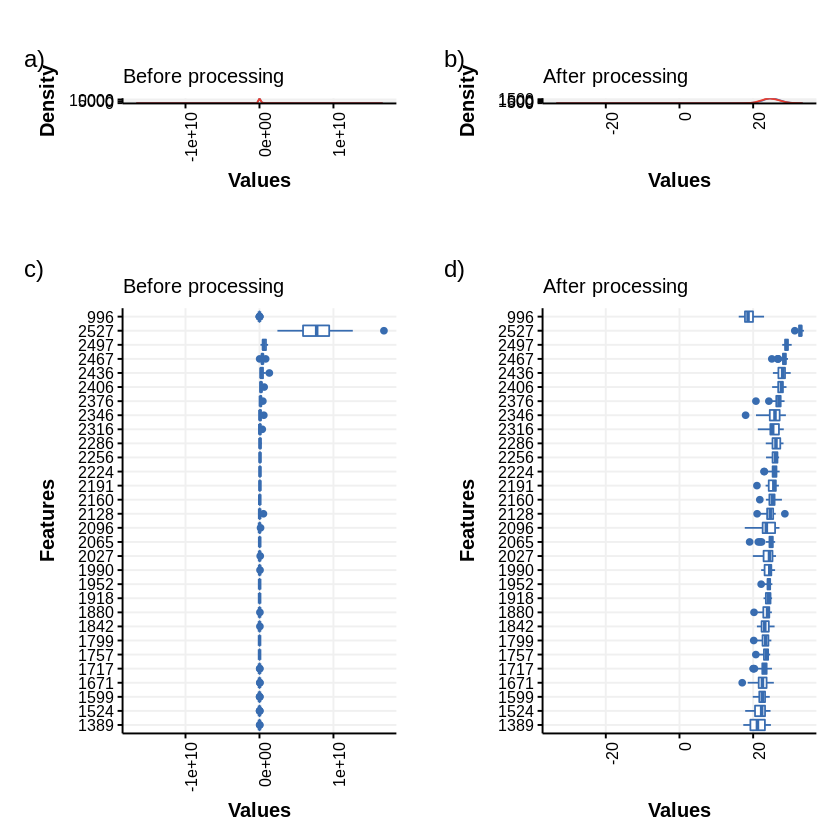

In [34]:
# distributions plot
C = compare_dist(factor_name = 'treatment')
g=chart_plot(C,DS,DSTFI)



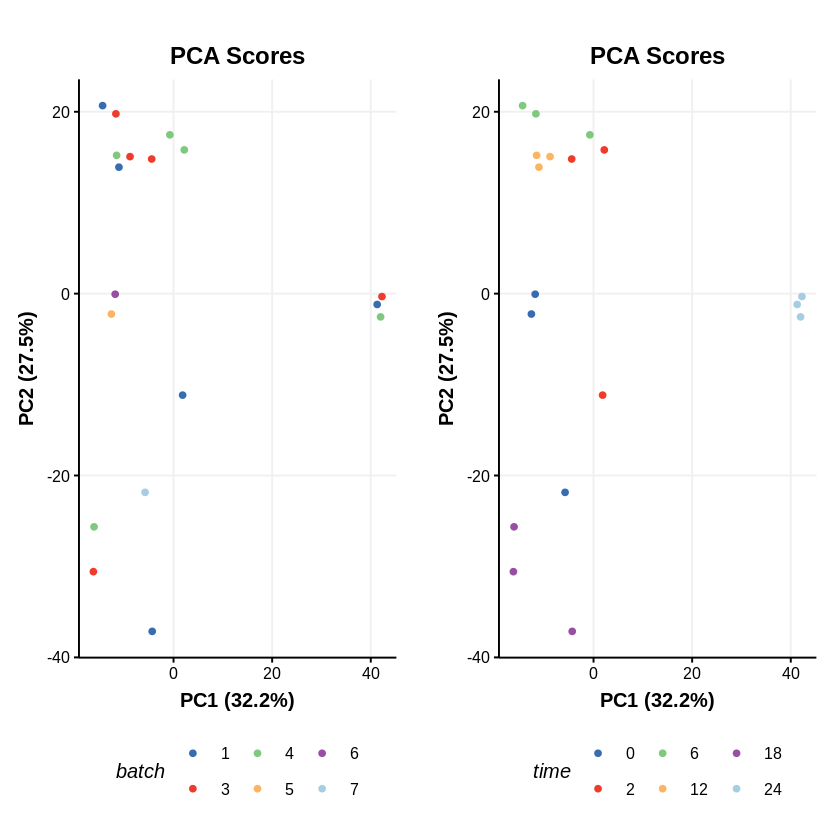

In [35]:
# model sequence
P = filter_smeta(mode='include',factor_name='treatment',levels='IKA') +
    mean_centre() + 
    PCA(number_components = 2)
# apply model
P = model_apply(P,DSTFI)

# scores plots coloured by factors
g = list()
for (k in c('batch','time')) {
  C = pca_scores_plot(factor_name=k,ellipse='none')
  g[[k]]=chart_plot(C,P[3])
}

plot_grid(plotlist = g,nrow=1)

The values are no longer skewed and show an approximately normal distribution. The boxplots are comparable in width with very few outliers indicated, so the transformations etc have had an overall positive effect.

There does not appear to be a strong batch effect. PC1 is dominated by time point “24” and some potentially outlying points from time points “2” and “0”.

In [32]:
# Metabolomics dataset
# path to zip
zipfile = "https://raw.github.com/STATegraData/STATegraData/master/Script_STATegra_Metabolomics.zip"

## retrieve from BiocFileCache
path = bfcrpath(bfc,zipfile)
temp = bfccache(bfc)

## ... or download to temp location
# path = tempfile()
# temp = tempdir()
# download.file(zipfile,path)

# unzip
unzip(zipfile=path, files = "LC_MS_raw_data.xlsx", exdir=temp)

# read samples
data <- as.data.frame(read.xlsx(file.path(temp,"LC_MS_raw_data.xlsx"),sheet = 'Data'))

adding rname 'https://raw.github.com/STATegraData/STATegraData/master/Script_STATegra_Metabolomics.zip'



In [33]:
# extract sample meta data
SM = data[ ,1:8]

# add coloumn for sample type (QC, blank etc)
blanks=c(1,2,33,34,65,66)
QCs=c(3,4,11,18,25,32,35,36,43,50,57,64)
SM$sample_type='Sample'
SM$sample_type[blanks]='Blank'
SM$sample_type[QCs]='QC'

# put qc/blank labels in all factors for plotting later
SM$biol.batch[SM$sample_type!='Sample']=SM$sample_type[SM$sample_type!='Sample']
SM$time.point[SM$sample_type!='Sample']=SM$sample_type[SM$sample_type!='Sample']
SM$condition[SM$sample_type!='Sample']=SM$sample_type[SM$sample_type!='Sample']

# convert to factors
SM$biol.batch=ordered(SM$biol.batch,c('9','10','11','12','QC','Blank'))
SM$time.point=ordered(SM$time.point,c('0h','2h','6h','12h','18h','24h','QC','Blank'))
SM$condition=factor(SM$condition)
SM$sample_type=factor(SM$sample_type)

# variable meta data
VM = data.frame('annotation'=colnames(data)[9:ncol(data)])

# raw data
X = data[,9:ncol(data)]
# convert 0 to NA
X[X==0]=NA
# force to numeric; any non-numerics will become NA
X=data.frame(lapply(X,as.numeric),check.names = FALSE)

# make sure row/col names match
rownames(X)=data$label
rownames(SM)=data$label
rownames(VM)=colnames(X)


# create DatasetExperiment object
DE = DatasetExperiment(
  data = X, 
  sample_meta = SM, 
  variable_meta = VM, 
  name = 'STATegra Metabolomics LCMS',
  description = 'https://www.nature.com/articles/s41597-019-0202-7'
)

DE

A "DatasetExperiment" object
----------------------------
name:          STATegra Metabolomics LCMS
description:   https://www.nature.com/articles/s41597-019-0202-7
data:          66 rows x 152 columns
sample_meta:   66 rows x 9 columns
variable_meta: 152 rows x 1 columns

In [36]:
# prepare model sequence
MS = filter_smeta(mode = 'include', levels='QC', factor_name = 'sample_type') +
     knn_impute(neighbours=5) +
     vec_norm() + 
     log_transform(base = 10) 

# apply model sequence
MS = model_apply(MS, DE)

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“3 rows with more than 50 % entries missing;
 mean imputation used for these rows”


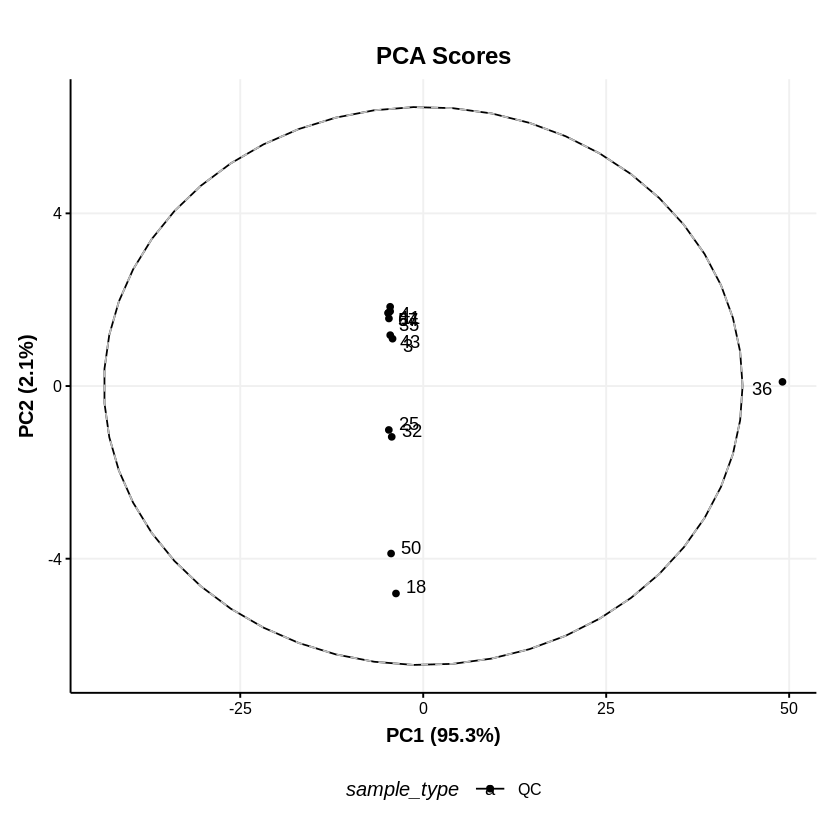

In [37]:
# pca model sequence
M =  mean_centre() +
     PCA(number_components = 3)

# apply model
M = model_apply(M,predicted(MS))


# PCA scores plot
C = pca_scores_plot(factor_name = 'sample_type',label_factor = 'order',points_to_label = 'all')
# plot
chart_plot(C,M[2])

In [38]:
# remove QC 36

# prepare model sequence
MS = filter_smeta(
      mode = 'include', 
      levels='QC', 
      factor_name = 'sample_type') +
  
     filter_by_name(
      mode = 'exclude', 
      dimension='sample',
      names = c('1358BZU_0001QC_H1','1358BZU_0001QC_A1','1358BZU_0001QC_G1')) +
  
     knn_impute(
      neighbours=5) +
  
     vec_norm() + 
  
     log_transform(
       base = 10) + 
  
     mean_centre() +
  
     PCA(
       number_components = 3)

# apply model sequence
MS = model_apply(MS, DE)

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“4 rows with more than 50 % entries missing;
 mean imputation used for these rows”


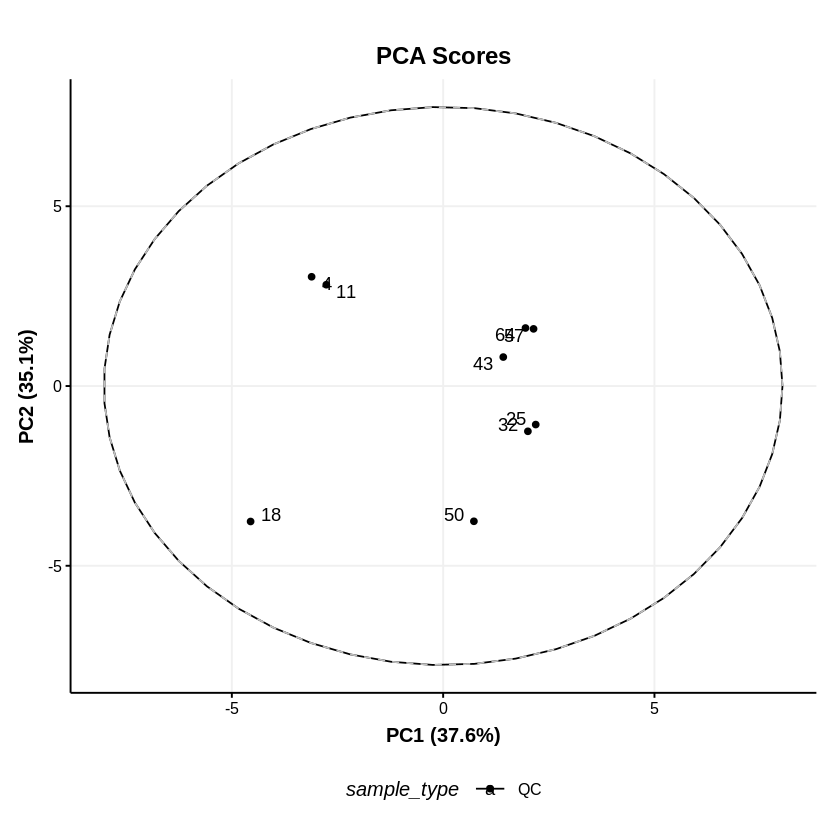

In [39]:
# PCA scores plot
C = pca_scores_plot(factor_name = 'sample_type',label_factor = 'order',points_to_label = 'all')
# plot
chart_plot(C,MS[7])

Now we will plot the QC samples in context with the samples. There are several possible approaches, and we will apply the approach of applying PCA to the full dataset including the QCs. We will exclude the blanks as it is likely that they will dominate the plot if not removed. All samples from batch 12 were excluded from STATegra and we will replicate that here.



In [40]:
# prepare model sequence
MS = filter_smeta(
      mode = 'exclude', 
      levels='Blank', 
      factor_name = 'sample_type') +
  
     filter_smeta(
      mode = 'exclude', 
      levels='12', 
      factor_name = 'biol.batch') +
  
     filter_by_name(
      mode = 'exclude', 
      dimension='sample',
      names = c('1358BZU_0001QC_H1',
                '1358BZU_0001QC_A1',
                '1358BZU_0001QC_G1')) +
  
     knn_impute(
      neighbours=5) +
  
     vec_norm() + 
  
     log_transform(
       base = 10) + 
  
     mean_centre() +
  
     PCA(
       number_components = 3)

# apply model sequence
MS = model_apply(MS, DE)

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“2 rows with more than 50 % entries missing;
 mean imputation used for these rows”


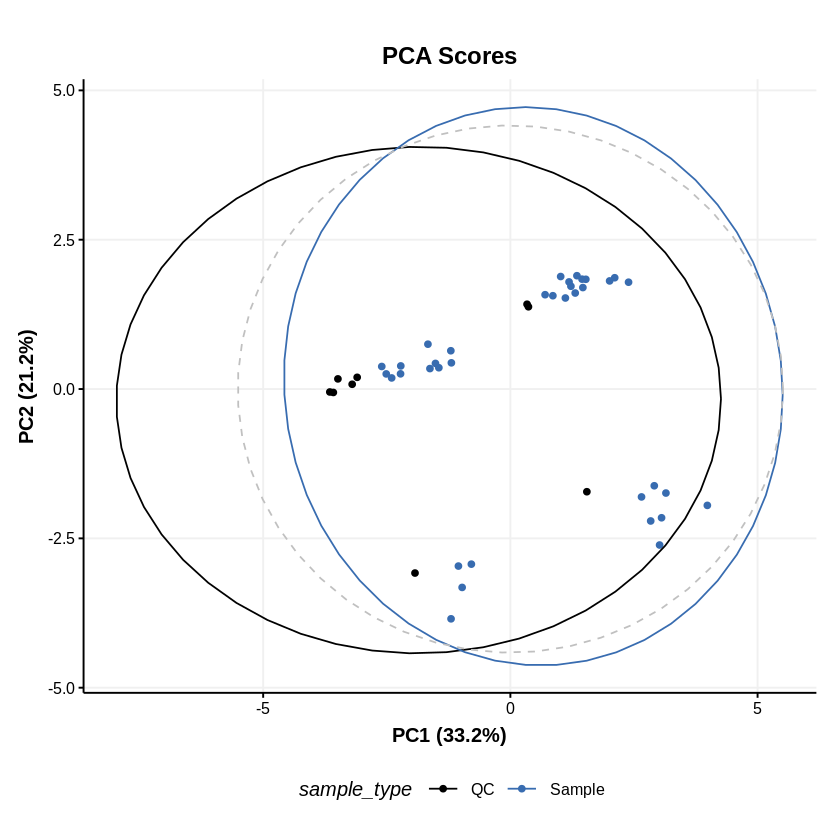

In [41]:
# PCA scores plots
C = pca_scores_plot(factor_name = 'sample_type')
# plot
chart_plot(C,MS[8])

The QCs appear to representative of the samples, but there are strong clusters in the data, including the QC samples which have no biological variation. There is likely to be a number of ‘low quality’ features that should be excluded, so we will do that now, and use more sophisticated normalisation (PQN) and scaling methods (glog).

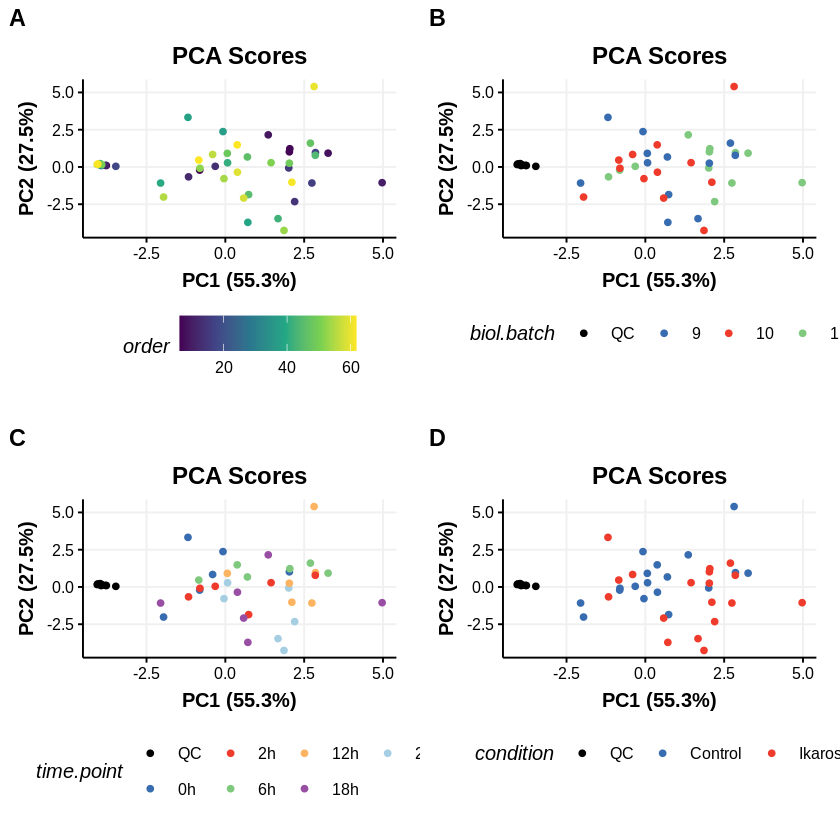

In [42]:
MS =  filter_smeta(
       mode = 'exclude', 
       levels = '12', 
       factor_name = 'biol.batch') +
  
      filter_by_name(
       mode = 'exclude', 
       dimension='sample',
       names = c('1358BZU_0001QC_H1',
                 '1358BZU_0001QC_A1',
                 '1358BZU_0001QC_G1')) +

      blank_filter(
       fold_change = 20,
       qc_label = 'QC',
       factor_name = 'sample_type') +

      filter_smeta(
       mode='exclude',
       levels='Blank',
       factor_name='sample_type') +
  
      mv_feature_filter(
       threshold = 80, 
       qc_label = 'QC', 
       factor_name = 'sample_type', 
       method = 'QC') +
     
      mv_feature_filter(
        threshold = 50, 
        factor_name = 'sample_type', 
        method='across') +
  
     rsd_filter(
       rsd_threshold=20, 
       qc_label='QC',
       factor_name='sample_type') +
  
     mv_sample_filter(
       mv_threshold = 50) +
     
     pqn_norm(
       qc_label='QC',
       factor_name='sample_type') +
     
     knn_impute(
       neighbours=5, 
       by='samples') +
     
     glog_transform(
       qc_label = 'QC',
       factor_name = 'sample_type') +
     
     mean_centre() + 
     
     PCA(
       number_components = 10)

# apply model sequence
MS = model_apply(MS, DE)


# PCA plots using different factors
g=list()
for (k in c('order','biol.batch','time.point','condition')) {
  C = pca_scores_plot(factor_name = k,ellipse='none')
  # plot
  g[[k]]=chart_plot(C,MS[length(MS)])
}

plot_grid(plotlist = g,align='vh',axis='tblr',nrow=2,labels=c('A','B','C','D'))

We can see now that the QCs are tightly clustered. This indicates that the biological variance of the remaining high quality features is much greater than the technical variance represented by the QCs.

There does not appear to be a trend by measurement order (A), which is an important indicator that instrument drift throughout the run is not a large source of variation in this dataset.

There does not appear to be strong clustering related to biological batch (B).

There does not appear to be a strong trend with time (C) but this is likely to be a more subtle variation and might be masked by other sources of variance at this stage.

There is some clustering related to condition (D) but with overlap.

To further explore any trends with time, we will split the data by the condition factor and only explore the Ikaros group. Removing the condition factor variation will potentially make it easier to spot any more subtle trends. We will extract the glog transformed matrix from the previous model sequence and continue from there.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



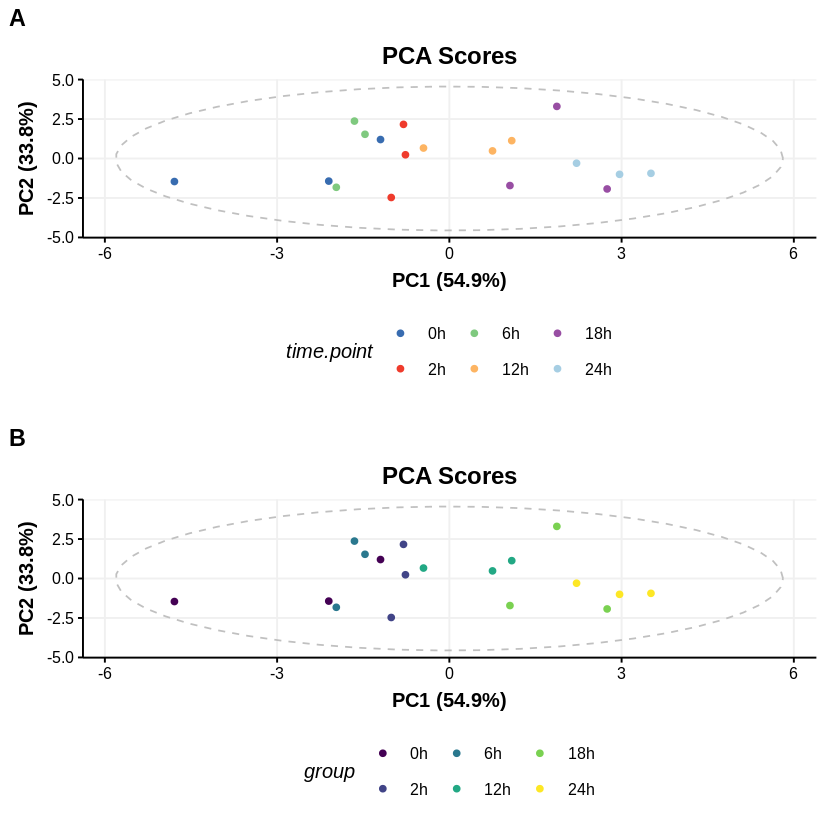

In [43]:
# get the glog scaled data
GL = predicted(MS[11])

# extract the Ikaros group and apply PCA
IK = filter_smeta(
      mode='include',
      factor_name='condition',
      levels='Ikaros') +
     mean_centre() + 
     PCA(number_components = 5)

# apply the model sequence to glog transformed data
IK = model_apply(IK,GL)

# plot the PCA scores
C = pca_scores_plot(factor_name='time.point',ellipse = 'sample')
g1=chart_plot(C,IK[3])
g2=g1 + scale_color_viridis_d() # add continuous scale colouring

plot_grid(g1,g2,nrow=2,align='vh',axis = 'tblr',labels=c('A','B'))